# Draft 1

In [2]:
!pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 939.5/939.5 kB 14.3 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.1/101.1 kB 5.8 MB/s eta 0:00:00
  Created wheel for peewee: filename=peewee-3.17.7-cp310-cp310-linux_x86_64.whl size=300450 sha256=2171c29ad83a6b9dad1b51112e6d200b9469238aab984e23fa18787e4a3da6f1
  Stored in directory: /root/.cache/pip/wheels/8d/0e/f8/48eb93a200fca4c502d7590613616fa4d2c9533f7308f9e28a
Successfully built peewee


In [6]:
class RobustPortfolioOptimizer:
    def __init__(self, returns_data):
        """
        Initialize the optimizer with historical returns data
        
        Parameters:
        returns_data (pd.DataFrame): Historical returns data
        """
        self.returns = returns_data
        self.n_assets = returns_data.shape[1]
        
    def calculate_historical_var(self, weights, confidence_level=0.95):
        """
        Calculate Historical VaR
        """
        portfolio_returns = self.returns @ weights
        return -np.percentile(portfolio_returns, (1 - confidence_level) * 100)
    
    def calculate_historical_cvar(self, weights, confidence_level=0.95):
        """
        Calculate Historical CVaR
        """
        portfolio_returns = self.returns @ weights
        var = -np.percentile(portfolio_returns, (1 - confidence_level) * 100)
        return -np.mean(portfolio_returns[portfolio_returns <= -var])
    
    def calculate_modified_sharpe(self, weights):
        """
        Calculate Modified Sharpe Ratio using CVaR instead of standard deviation
        """
        portfolio_returns = self.returns @ weights
        mean_return = np.mean(portfolio_returns)
        cvar = self.calculate_historical_cvar(weights)
        return mean_return / cvar if cvar != 0 else -np.inf
    
    def optimize_portfolio(self, objective='modified_sharpe', constraints=None):
        """
        Optimize portfolio based on selected objective
        
        Parameters:
        objective (str): 'modified_sharpe', 'min_cvar', or 'mean_cvar'
        constraints (dict): Additional constraints for optimization
        """
        initial_weights = np.array([1/self.n_assets] * self.n_assets)
        
        bounds = tuple((0, 1) for _ in range(self.n_assets))
        
        # Basic constraints
        constraints_list = [
            {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}  # weights sum to 1
        ]
        
        if constraints:
            # Add user-defined constraints
            if 'min_weight' in constraints:
                constraints_list.append(
                    {'type': 'ineq', 'fun': lambda x: x - constraints['min_weight']}
                )
            if 'max_weight' in constraints:
                constraints_list.append(
                    {'type': 'ineq', 'fun': lambda x: constraints['max_weight'] - x}
                )
        
        if objective == 'modified_sharpe':
            objective_function = lambda x: -self.calculate_modified_sharpe(x)
        elif objective == 'min_cvar':
            objective_function = lambda x: self.calculate_historical_cvar(x)
        elif objective == 'mean_cvar':
            def objective_function(x):
                returns = np.mean(self.returns @ x)
                cvar = self.calculate_historical_cvar(x)
                return -(returns - 0.5 * cvar)  # Parameter 0.5 can be adjusted
                
        result = minimize(objective_function,
                         initial_weights,
                         method='SLSQP',
                         bounds=bounds,
                         constraints=constraints_list)
        
        return result.x
    
    def calculate_portfolio_metrics(self, weights):
        """
        Calculate comprehensive portfolio metrics
        """
        portfolio_returns = self.returns @ weights
        metrics = {
            'mean_return': np.mean(portfolio_returns),
            'volatility': np.std(portfolio_returns),
            'historical_var_95': self.calculate_historical_var(weights),
            'historical_cvar_95': self.calculate_historical_cvar(weights),
            'modified_sharpe': self.calculate_modified_sharpe(weights),
            'skewness': stats.skew(portfolio_returns),
            'kurtosis': stats.kurtosis(portfolio_returns)
        }
        return metrics

In [7]:
import numpy as np
import pandas as pd
import yfinance as yf
from scipy import stats
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

class PortfolioAnalyzer:
    def __init__(self, start_date, end_date):
        self.start_date = start_date
        self.end_date = end_date
        
    def get_data(self, tickers):
        """
        Mengambil dan memproses data historis
        """
        data = pd.DataFrame()
        valid_tickers = []
        
        print("Mengunduh data...")
        for ticker in tickers:
            try:
                stock = yf.download(ticker, start=self.start_date, end=self.end_date)
                if not stock.empty and len(stock) > 0:
                    returns = stock['Adj Close'].pct_change()
                    if len(returns.dropna()) > 0:
                        data[ticker] = returns
                        valid_tickers.append(ticker)
            except Exception as e:
                print(f"Error mengunduh {ticker}: {e}")
                
        data = data.dropna()
        return data, valid_tickers
    
    def analyze_individual_stocks(self, returns_data):
        """
        Analisis metrik individual saham
        """
        metrics = pd.DataFrame()
        
        for col in returns_data.columns:
            returns = returns_data[col]
            metrics.loc[col, 'Mean Return'] = returns.mean()
            metrics.loc[col, 'Volatility'] = returns.std()
            metrics.loc[col, 'Sharpe Ratio'] = returns.mean() / returns.std()
            metrics.loc[col, 'Skewness'] = stats.skew(returns)
            metrics.loc[col, 'Kurtosis'] = stats.kurtosis(returns)
            
        return metrics.sort_values('Sharpe Ratio', ascending=False)
    
    def optimize_portfolio(self, returns_data, n_portfolios=1000):
        """
        Optimasi portofolio dengan berbagai objective
        """
        optimizer = RobustPortfolioOptimizer(returns_data)
        
        # Optimasi dengan berbagai objective
        results = {
            'modified_sharpe': optimizer.optimize_portfolio(objective='modified_sharpe'),
            'min_cvar': optimizer.optimize_portfolio(objective='min_cvar'),
            'mean_cvar': optimizer.optimize_portfolio(objective='mean_cvar')
        }
        
        # Hitung metrik untuk setiap portofolio
        portfolio_metrics = {}
        for objective, weights in results.items():
            metrics = optimizer.calculate_portfolio_metrics(weights)
            portfolio_metrics[objective] = {
                'weights': pd.Series(weights, index=returns_data.columns),
                'metrics': metrics
            }
            
        return portfolio_metrics
    
    def generate_efficient_frontier(self, returns_data, n_points=100):
        """
        Generate efficient frontier using CVaR as risk measure
        """
        optimizer = RobustPortfolioOptimizer(returns_data)
        frontier_points = []
        
        min_risk_weights = optimizer.optimize_portfolio(objective='min_cvar')
        max_return_weights = optimizer.optimize_portfolio(objective='modified_sharpe')
        
        min_return = optimizer.calculate_portfolio_metrics(min_risk_weights)['mean_return']
        max_return = optimizer.calculate_portfolio_metrics(max_return_weights)['mean_return']
        
        target_returns = np.linspace(min_return, max_return, n_points)
        
        for target in target_returns:
            constraints = [
                {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
                {'type': 'eq', 'fun': lambda x: np.mean(returns_data @ x) - target}
            ]
            
            weights = optimizer.optimize_portfolio(objective='min_cvar', constraints=constraints)
            metrics = optimizer.calculate_portfolio_metrics(weights)
            
            frontier_points.append({
                'return': metrics['mean_return'],
                'risk': metrics['historical_cvar_95'],
                'weights': weights
            })
            
        return pd.DataFrame(frontier_points)
    
    def plot_efficient_frontier(self, frontier_data):
        """
        Plot efficient frontier
        """
        plt.figure(figsize=(10, 6))
        plt.scatter(frontier_data['risk'], frontier_data['return'], c='b', marker='o')
        plt.xlabel('Risk (CVaR)')
        plt.ylabel('Expected Return')
        plt.title('Efficient Frontier using CVaR')
        return plt

In [8]:
def run_portfolio_analysis(tickers, start_date, end_date):
    """
    Fungsi utama untuk menjalankan analisis portofolio lengkap
    """
    analyzer = PortfolioAnalyzer(start_date, end_date)
    
    # 1. Pengumpulan dan preprocessing data
    returns_data, valid_tickers = analyzer.get_data(tickers)
    print(f"\nBerhasil mengunduh data untuk {len(valid_tickers)} saham")
    
    # 2. Analisis individual saham
    stock_metrics = analyzer.analyze_individual_stocks(returns_data)
    print("\nMetrik Individual Saham:")
    print(stock_metrics)
    
    # 3. Optimasi portofolio
    portfolio_results = analyzer.optimize_portfolio(returns_data)
    
    # 4. Generate efficient frontier
    frontier_data = analyzer.generate_efficient_frontier(returns_data)
    
    # 5. Visualisasi
    plt = analyzer.plot_efficient_frontier(frontier_data)
    
    return {
        'returns_data': returns_data,
        'stock_metrics': stock_metrics,
        'portfolio_results': portfolio_results,
        'frontier_data': frontier_data,
        'plot': plt
    }

# Fungsi helper untuk format output
def format_portfolio_results(results):
    """
    Format hasil analisis portofolio untuk tampilan yang lebih baik
    """
    for objective, data in results['portfolio_results'].items():
        print(f"\nPortfolio Optimization - {objective}")
        print("\nBobot Optimal:")
        weights = data['weights'][data['weights'] > 0.01]  # Filter bobot > 1%
        print(weights.round(4))
        print("\nMetrik Portfolio:")
        metrics = pd.Series(data['metrics']).round(4)
        print(metrics)

Mengunduh data...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********


Berhasil mengunduh data untuk 34 saham

Metrik Individual Saham:
         Mean Return  Volatility  Sharpe Ratio  Skewness   Kurtosis
ARTO.JK     0.004112    0.053714      0.076550  1.729835   8.385520
ITMG.JK     0.001632    0.026530      0.061519  0.846647   4.003573
BRIS.JK     0.002297    0.038930      0.059002  2.540447  13.262125
HRUM.JK     0.001852    0.032575      0.056841  1.279025   5.795602
ISAT.JK     0.002038    0.036415      0.055958  4.396100  55.683002
ESSA.JK     0.001927    0.041364      0.046580  1.613142   7.780513
BMRI.JK     0.000983    0.021386      0.045987  0.193904   5.834536
PTBA.JK     0.001127    0.026310      0.042841  0.880907  10.241345
BBCA.JK     0.000663    0.015976      0.041472  1.063046  13.646681
UNTR.JK     0.000921    0.024674      0.037309  0.983696   6.315240
MEDC.JK     0.001298    0.035320      0.036758  0.765250   3.686768
MDKA.JK     0.001038    0.030823      0.033682  0.939475   4.509056
BBRI.JK     0.000638    0.021022      0.030348  0.

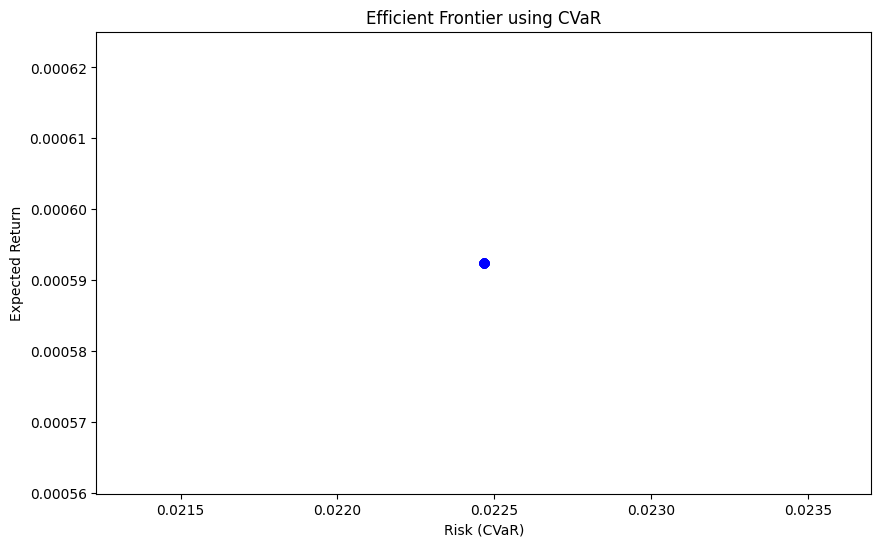

In [9]:
# Daftar kode saham LQ45 terbaru
# Ada beberapa saham yang dieliminasi karena data harga saham baru muncul setelah range yang ditentukan
# AMMN -> 7/7/2023
# BUKA -> 8/6/2021
# GOTO -> 4/11/2022
# MBMA -> 4/18/2023
# MTEL -> 11/22/2021
# PGEO -> 2/24/2023
lq45_tickers = [
    'ACES.JK', 'ADRO.JK', 'AKRA.JK', 'AMRT.JK', 'ANTM.JK',
    'ARTO.JK', 'ASII.JK', 'BBCA.JK', 'BBNI.JK', 'BBRI.JK',
    'BMRI.JK', 'BRIS.JK', 'BRPT.JK', 'CPIN.JK', 'ESSA.JK',
    'EXCL.JK', 'GGRM.JK', 'HRUM.JK', 'ICBP.JK', 'INCO.JK',
    'INDF.JK', 'INKP.JK', 'INTP.JK', 'ISAT.JK', 'ITMG.JK',
    'KLBF.JK', 'MAPI.JK', 'MDKA.JK', 'MEDC.JK', 'BBTN.JK',
    'PGAS.JK', 'PTBA.JK', 'SIDO.JK', 'SMGR.JK', 'TLKM.JK',
    'TOWR.JK', 'UNTR.JK', 'UNVR.JK', 'JSMR.JK',
]

# Periode analisis
start_date = '2019-09-01'
end_date = '2024-09-01'

# Jalankan analisis
results = run_portfolio_analysis(lq45_tickers, start_date, end_date)

# Tampilkan hasil
format_portfolio_results(results)

# Draft 2

In [5]:
class RobustPortfolioOptimizer:
    def __init__(self, returns_data):
        self.returns = returns_data

    def calculate_historical_var(self, weights, confidence_level=0.95):
        portfolio_returns = self.returns @ weights
        return -np.percentile(portfolio_returns, (1 - confidence_level) * 100)

    def calculate_historical_cvar(self, weights, confidence_level=0.95):
        portfolio_returns = self.returns @ weights
        var = -np.percentile(portfolio_returns, (1 - confidence_level) * 100)
        return -np.mean(portfolio_returns[portfolio_returns <= -var])

    def calculate_modified_sharpe(self, weights):
        portfolio_returns = self.returns @ weights
        mean_return = np.mean(portfolio_returns)
        cvar = self.calculate_historical_cvar(weights)
        return mean_return / cvar if cvar != 0 else -np.inf

    def optimize_portfolio(self, returns_data, objective='modified_sharpe', constraints=None):
        """
        Optimize portfolio based on selected objective
        """
        initial_weights = np.array([1/returns_data.shape[1]] * returns_data.shape[1])
        bounds = tuple((0, 1) for _ in range(returns_data.shape[1]))

        # Basic constraints
        constraints_list = [
            {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
        ]

        if constraints:
            if 'min_weight' in constraints:
                constraints_list.append(
                    {'type': 'ineq', 'fun': lambda x: x - constraints['min_weight']}
                )
            if 'max_weight' in constraints:
                constraints_list.append(
                    {'type': 'ineq', 'fun': lambda x: constraints['max_weight'] - x}
                )

        if objective == 'modified_sharpe':
            objective_function = lambda x: -self.calculate_modified_sharpe(x)
        elif objective == 'min_cvar':
            objective_function = lambda x: self.calculate_historical_cvar(x)
        elif objective == 'mean_cvar':
            def objective_function(x):
                returns = np.mean(returns_data @ x)
                # cvar = self.calculate_historical_cvar(x, returns_data)
                cvar = self.calculate_historical_cvar(x)  # Fixed this line
                return -(returns - 0.5 * cvar)

        result = minimize(objective_function,
                         initial_weights,
                         method='SLSQP',
                         bounds=bounds,
                         constraints=constraints_list)

        return result.x

    def calculate_portfolio_metrics(self, returns_data, weights):
        """
        Calculate comprehensive portfolio metrics
        """
        portfolio_returns = returns_data @ weights
        metrics = {
            'mean_return': np.mean(portfolio_returns),
            'volatility': np.std(portfolio_returns),
            # 'historical_var_95': self.calculate_historical_var(weights, returns_data),
            'historical_var_95': self.calculate_historical_var(weights),
            # 'historical_cvar_95': self.calculate_historical_cvar(weights, returns_data),
            'historical_cvar_95': self.calculate_historical_cvar(weights),
            'modified_sharpe': self.calculate_modified_sharpe(weights),
            'skewness': stats.skew(portfolio_returns),
            'kurtosis': stats.kurtosis(portfolio_returns)
        }
        return metrics

In [22]:
def get_historical_data(tickers, start_date, end_date):
    """
    Fetch historical data using yfinance
    """
    data = pd.DataFrame()
    for ticker in tickers:
        stock = yf.download(ticker, start=start_date, end=end_date)
        data[ticker] = stock['Adj Close'].pct_change()
    return data.dropna()

def run_portfolio_analysis(tickers, start_date, end_date, window_size=252):
    """
    Main function to run comprehensive portfolio analysis
    """
    # 1. Collect and preprocess data
    returns_data = get_historical_data(tickers, start_date, end_date)
    print(f"Successfully downloaded data for {returns_data.shape[1]} stocks")

    # 2. Analyze individual stocks
    optimizer = RobustPortfolioOptimizer(returns_data)
    stock_metrics = pd.DataFrame({
        'Mean Return': returns_data.mean(),
        'Volatility': returns_data.std(),
        'Sharpe Ratio': returns_data.mean() / returns_data.std(),
        'Skewness': returns_data.skew(),
        'Kurtosis': returns_data.kurtosis()
    }).sort_values('Sharpe Ratio', ascending=False)
    print("\nIndividual Stock Metrics:")
    print(stock_metrics)

    # 3. Optimize portfolios
    portfolio_results = {
        'modified_sharpe': optimizer.optimize_portfolio(returns_data, objective='modified_sharpe'),
        'min_cvar': optimizer.optimize_portfolio(returns_data, objective='min_cvar'),
        'mean_cvar': optimizer.optimize_portfolio(returns_data, objective='mean_cvar')
    }

    # 4. Generate efficient frontier
    frontier_data = generate_efficient_frontier(returns_data, optimizer, window_size)

    # 5. Visualize results
    plot_efficient_frontier(frontier_data)

    return {
        'returns_data': returns_data,
        'stock_metrics': stock_metrics,
        'portfolio_results': portfolio_results,
        'frontier_data': frontier_data
    }

def generate_efficient_frontier(returns_data, optimizer, window_size):
    """
    Generate efficient frontier using CVaR as risk measure
    """
    frontier_points = []

    for start in range(0, len(returns_data) - window_size, window_size):
        window_returns = returns_data.iloc[start:start+window_size]
        min_risk_weights = optimizer.optimize_portfolio(window_returns, objective='min_cvar')
        max_return_weights = optimizer.optimize_portfolio(window_returns, objective='modified_sharpe')

        min_return = optimizer.calculate_portfolio_metrics(window_returns, min_risk_weights)['mean_return']
        max_return = optimizer.calculate_portfolio_metrics(window_returns, max_return_weights)['mean_return']

        target_returns = np.linspace(min_return, max_return, 100)

        for target in target_returns:
            constraints = [
                {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
                {'type': 'eq', 'fun': lambda x: np.mean(window_returns @ x) - target}
            ]
            weights = optimizer.optimize_portfolio(window_returns, objective='min_cvar', constraints=constraints)
            metrics = optimizer.calculate_portfolio_metrics(window_returns, weights)
            frontier_points.append({
                'start_date': returns_data.index[start],
                'return': metrics['mean_return'],
                'risk': metrics['historical_cvar_95'],
                'weights': weights
            })

    return pd.DataFrame(frontier_points)

def plot_efficient_frontier(frontier_data):
    """
    Plot efficient frontier
    """
    plt.figure(figsize=(10, 6))
    plt.scatter(frontier_data['risk'], frontier_data['return'], c='b', marker='o')
    plt.xlabel('Risk (CVaR)')
    plt.ylabel('Expected Return')
    plt.title('Efficient Frontier using CVaR')
    plt.show()

def format_portfolio_results(results):
    """
    Format portfolio analysis results for better display
    """
    for objective, data in results.items():
        print(f"\nPortfolio Optimization - {objective}")
        print("\nOptimal Weights:")

        # Check if returns_data is a DataFrame
        if isinstance(results['returns_data'], pd.DataFrame):
            weights = pd.Series(data['weights'], index=results['returns_data'].columns)
        else:
            # Convert returns_data to DataFrame with ticker names if it's an array
            tickers = [f"Stock_{i}" for i in range(len(data['weights']))]  # Replace with actual ticker names
            returns_df = pd.DataFrame(results['returns_data'], columns=tickers)
            weights = pd.Series(data['weights'], index=returns_df.columns)
        
        weights = weights[weights > 0.01]  # Filter weights > 1%
        print(weights.round(4))

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for 5 stocks

Individual Stock Metrics:
         Mean Return  Volatility  Sharpe Ratio  Skewness   Kurtosis
BBCA.JK     0.000663    0.015976      0.041472  1.064365  13.708129
BBRI.JK     0.000638    0.021022      0.030348  0.913668   9.291688
TLKM.JK     0.000066    0.018669      0.003509  0.663140   5.066191
GGRM.JK    -0.000733    0.023200     -0.031603  0.311398  13.604188
UNVR.JK    -0.000814    0.021629     -0.037624  1.360649  10.632596


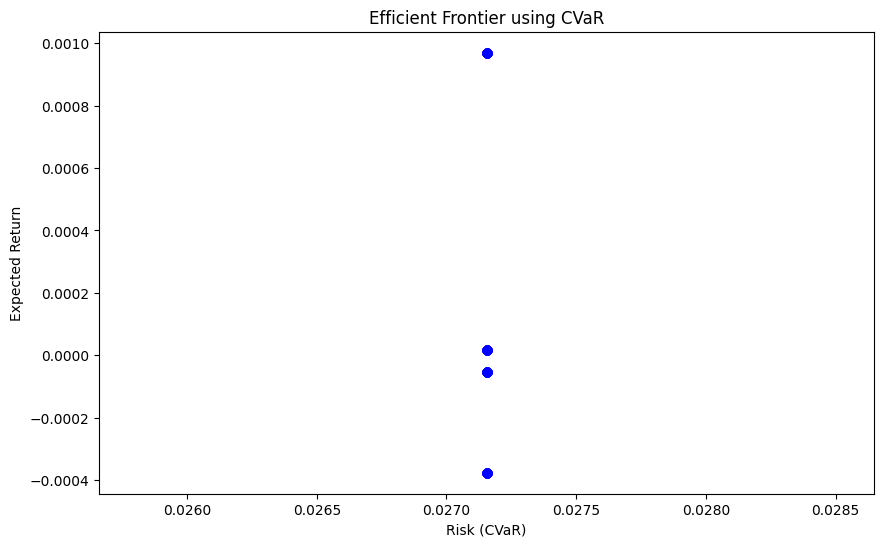


Portfolio Optimization - returns_data

Optimal Weights:


KeyError: 'weights'

In [23]:
# Daftar kode saham LQ45 terbaru
# Ada beberapa saham yang dieliminasi karena data harga saham baru muncul setelah range yang ditentukan
# AMMN -> 7/7/2023
# BUKA -> 8/6/2021
# GOTO -> 4/11/2022
# MBMA -> 4/18/2023
# MTEL -> 11/22/2021
# PGEO -> 2/24/2023
lq45_tickers = [
    'ACES.JK', 'ADRO.JK', 'AKRA.JK', 'AMRT.JK', 'ANTM.JK',
    'ARTO.JK', 'ASII.JK', 'BBCA.JK', 'BBNI.JK', 'BBRI.JK',
    'BMRI.JK', 'BRIS.JK', 'BRPT.JK', 'CPIN.JK', 'ESSA.JK',
    'EXCL.JK', 'GGRM.JK', 'HRUM.JK', 'ICBP.JK', 'INCO.JK',
    'INDF.JK', 'INKP.JK', 'INTP.JK', 'ISAT.JK', 'ITMG.JK',
    'KLBF.JK', 'MAPI.JK', 'MDKA.JK', 'MEDC.JK', 'BBTN.JK',
    'PGAS.JK', 'PTBA.JK', 'SIDO.JK', 'SMGR.JK', 'TLKM.JK',
    'TOWR.JK', 'UNTR.JK', 'UNVR.JK', 'JSMR.JK',
]
tickers = ['BBCA.JK', 'BBRI.JK', 'TLKM.JK', 'UNVR.JK', 'GGRM.JK']

# Periode analisis
start_date = '2019-09-01'
end_date = '2024-09-01'
window_size = 252  # 1 year rolling window

# Jalankan analisis
# results = run_portfolio_analysis(lq45_tickers, start_date, end_date)

# Tampilkan hasil
# format_portfolio_results(results)

results = run_portfolio_analysis(tickers, start_date, end_date, window_size)
format_portfolio_results(results)

# Draft 3

In [2]:
!pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 948.2/948.2 kB 13.0 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.1/101.1 kB 7.3 MB/s eta 0:00:00
  Created wheel for peewee: filename=peewee-3.17.8-cp310-cp310-linux_x86_64.whl size=300753 sha256=840175361ad195728f89b70750917ac52227b6cc1504e728eda85ebb889e1d36
  Stored in directory: /root/.cache/pip/wheels/75/79/e5/8838db0594cc6c587142fd2563356392ade6255c5930411069
Successfully built peewee


In [1]:
class RobustPortfolioOptimizer:
    def __init__(self, returns_data):
        """
        Initialize the optimizer with historical returns data
        
        Parameters:
        returns_data (pd.DataFrame): Historical returns data
        """
        self.returns = returns_data
        self.n_assets = returns_data.shape[1]
        
    def calculate_historical_var(self, weights, confidence_level=0.95):
        """
        Calculate Historical VaR
        """
        portfolio_returns = self.returns @ weights
        return -np.percentile(portfolio_returns, (1 - confidence_level) * 100)
    
    def calculate_historical_cvar(self, weights, confidence_level=0.95):
        """
        Calculate Historical CVaR
        """
        portfolio_returns = self.returns @ weights
        var = -np.percentile(portfolio_returns, (1 - confidence_level) * 100)
        return -np.mean(portfolio_returns[portfolio_returns <= -var])
    
    def calculate_modified_sharpe(self, weights):
        """
        Calculate Modified Sharpe Ratio using CVaR instead of standard deviation
        """
        portfolio_returns = self.returns @ weights
        mean_return = np.mean(portfolio_returns)
        cvar = self.calculate_historical_cvar(weights)
        return mean_return / cvar if cvar != 0 else -np.inf
    
    def optimize_portfolio(self, objective='modified_sharpe', constraints=None):
        """
        Optimize portfolio based on selected objective
        
        Parameters:
        objective (str): 'modified_sharpe', 'min_cvar', or 'mean_cvar'
        constraints (dict): Additional constraints for optimization
        """
        initial_weights = np.array([1/self.n_assets] * self.n_assets)
        
        bounds = tuple((0, 1) for _ in range(self.n_assets))
        
        # Basic constraints
        constraints_list = [
            {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}  # weights sum to 1
        ]
        
        if constraints:
            # Add user-defined constraints
            if 'min_weight' in constraints:
                constraints_list.append(
                    {'type': 'ineq', 'fun': lambda x: x - constraints['min_weight']}
                )
            if 'max_weight' in constraints:
                constraints_list.append(
                    {'type': 'ineq', 'fun': lambda x: constraints['max_weight'] - x}
                )
        
        if objective == 'modified_sharpe':
            objective_function = lambda x: -self.calculate_modified_sharpe(x)
        elif objective == 'min_cvar':
            objective_function = lambda x: self.calculate_historical_cvar(x)
        elif objective == 'mean_cvar':
            def objective_function(x):
                returns = np.mean(self.returns @ x)
                cvar = self.calculate_historical_cvar(x)
                return -(returns - 0.5 * cvar)  # Parameter 0.5 can be adjusted
                
        result = minimize(objective_function,
                         initial_weights,
                         method='SLSQP',
                         bounds=bounds,
                         constraints=constraints_list)
        
        return result.x
    
    def calculate_portfolio_metrics(self, weights):
        """
        Calculate comprehensive portfolio metrics
        """
        portfolio_returns = self.returns @ weights
        metrics = {
            'mean_return': np.mean(portfolio_returns),
            'volatility': np.std(portfolio_returns),
            'historical_var_95': self.calculate_historical_var(weights),
            'historical_cvar_95': self.calculate_historical_cvar(weights),
            'modified_sharpe': self.calculate_modified_sharpe(weights),
            'skewness': stats.skew(portfolio_returns),
            'kurtosis': stats.kurtosis(portfolio_returns)
        }
        return metrics

In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
from scipy import stats
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

class PortfolioAnalyzer:
    def __init__(self, start_date, end_date):
        self.start_date = start_date
        self.end_date = end_date
        
    def get_data(self, tickers):
        data = pd.DataFrame()
        valid_tickers = []
        
        print("Mengunduh data...")
        for ticker in tickers:
            try:
                stock = yf.download(ticker, start=self.start_date, end=self.end_date)
                if not stock.empty and len(stock) > 0:
                    returns = stock['Adj Close'].pct_change()
                    if len(returns.dropna()) > 0:
                        data[ticker] = returns
                        valid_tickers.append(ticker)
            except Exception as e:
                print(f"Error mengunduh {ticker}: {e}")
                
        data = data.dropna()
        return data, valid_tickers
    
    def analyze_individual_stocks(self, returns_data):
        metrics = pd.DataFrame()
        
        for col in returns_data.columns:
            returns = returns_data[col]
            metrics.loc[col, 'Mean Return'] = returns.mean()
            metrics.loc[col, 'Volatility'] = returns.std()
            metrics.loc[col, 'Sharpe Ratio'] = returns.mean() / returns.std()
            metrics.loc[col, 'Skewness'] = stats.skew(returns)
            metrics.loc[col, 'Kurtosis'] = stats.kurtosis(returns)
            
        return metrics.sort_values('Sharpe Ratio', ascending=False)
    
    def optimize_portfolio(self, returns_data, n_portfolios=1000):
        optimizer = RobustPortfolioOptimizer(returns_data)
        
        results = {
            'modified_sharpe': optimizer.optimize_portfolio(objective='modified_sharpe'),
            'min_cvar': optimizer.optimize_portfolio(objective='min_cvar'),
            'mean_cvar': optimizer.optimize_portfolio(objective='mean_cvar')
        }
        
        portfolio_metrics = {}
        for objective, weights in results.items():
            metrics = optimizer.calculate_portfolio_metrics(weights)
            portfolio_metrics[objective] = {
                'weights': pd.Series(weights, index=returns_data.columns),
                'metrics': metrics
            }
            
        return portfolio_metrics
    
    def generate_efficient_frontier(self, returns_data, n_points=100):
        optimizer = RobustPortfolioOptimizer(returns_data)
        frontier_points = []
        
        min_risk_weights = optimizer.optimize_portfolio(objective='min_cvar')
        max_return_weights = optimizer.optimize_portfolio(objective='modified_sharpe')
        
        min_return = optimizer.calculate_portfolio_metrics(min_risk_weights)['mean_return']
        max_return = optimizer.calculate_portfolio_metrics(max_return_weights)['mean_return']
        
        target_returns = np.linspace(min_return, max_return, n_points)
        
        for target in target_returns:
            constraints = [
                {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
                {'type': 'eq', 'fun': lambda x: np.mean(returns_data @ x) - target}
            ]
            
            weights = optimizer.optimize_portfolio(objective='min_cvar', constraints=constraints)
            metrics = optimizer.calculate_portfolio_metrics(weights)
            
            frontier_points.append({
                'return': metrics['mean_return'],
                'risk': metrics['historical_cvar_95'],
                'weights': weights
            })
            
        return pd.DataFrame(frontier_points)
    
    def calculate_benchmark_performance(self, returns_data):
        equal_weights = np.ones(len(returns_data.columns)) / len(returns_data.columns)
        mean_return = np.dot(returns_data.mean(), equal_weights)
        portfolio_std = np.sqrt(np.dot(equal_weights.T, np.dot(returns_data.cov(), equal_weights)))
        sharpe_ratio = mean_return / portfolio_std
        
        return {
            'Mean Return': mean_return,
            'Volatility': portfolio_std,
            'Sharpe Ratio': sharpe_ratio
        }
    
    def monte_carlo_simulation(self, returns_data, n_simulations=1000):
        simulation_results = []
        
        for _ in range(n_simulations):
            simulated_returns = returns_data.sample(frac=1, replace=True)
            optimal_portfolio = self.optimize_portfolio(simulated_returns)
            simulation_results.append({
                'modified_sharpe': optimal_portfolio['modified_sharpe']['metrics'],
                'min_cvar': optimal_portfolio['min_cvar']['metrics'],
                'mean_cvar': optimal_portfolio['mean_cvar']['metrics']
            })
        
        return pd.DataFrame(simulation_results)
    
    def plot_portfolio_weights(self, portfolio_results):
        fig, ax = plt.subplots(1, 3, figsize=(18, 6))
        for idx, (objective, data) in enumerate(portfolio_results.items()):
            data['weights'].plot(kind='bar', ax=ax[idx], title=objective.capitalize())
            ax[idx].set_ylabel("Weights")
        
        plt.suptitle("Portfolio Weights by Optimization Objective")
        plt.show()
    
    def plot_efficient_frontier(self, frontier_data):
        plt.figure(figsize=(10, 6))
        plt.scatter(frontier_data['risk'], frontier_data['return'], c='b', marker='o')
        plt.xlabel('Risk (CVaR)')
        plt.ylabel('Expected Return')
        plt.title('Efficient Frontier using CVaR')
        return plt

def run_portfolio_analysis(tickers, start_date, end_date):
    analyzer = PortfolioAnalyzer(start_date, end_date)
    
    returns_data, valid_tickers = analyzer.get_data(tickers)
    print(f"\nBerhasil mengunduh data untuk {len(valid_tickers)} saham")
    
    stock_metrics = analyzer.analyze_individual_stocks(returns_data)
    print("\nMetrik Individual Saham:")
    print(stock_metrics)
    
    portfolio_results = analyzer.optimize_portfolio(returns_data)
    frontier_data = analyzer.generate_efficient_frontier(returns_data)
    
    benchmark_performance = analyzer.calculate_benchmark_performance(returns_data)
    print("\nBenchmark Performance:")
    print(benchmark_performance)
    
    monte_carlo_results = analyzer.monte_carlo_simulation(returns_data)
    print("\nMonte Carlo Simulation Results (sample):")
    print(monte_carlo_results.head())
    
    plt = analyzer.plot_efficient_frontier(frontier_data)
    analyzer.plot_portfolio_weights(portfolio_results)
    
    return {
        'returns_data': returns_data,
        'stock_metrics': stock_metrics,
        'portfolio_results': portfolio_results,
        'frontier_data': frontier_data,
        'benchmark_performance': benchmark_performance,
        'monte_carlo_results': monte_carlo_results,
        'plot': plt
    }


### sample

Mengunduh data...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Berhasil mengunduh data untuk 5 saham

Metrik Individual Saham:
         Mean Return  Volatility  Sharpe Ratio  Skewness   Kurtosis
BBCA.JK     0.000663    0.015976      0.041472  1.063047  13.646702
BBRI.JK     0.000638    0.021022      0.030348  0.912537   9.248467
TLKM.JK     0.000066    0.018669      0.003509  0.662321   5.040380
GGRM.JK    -0.000733    0.023200     -0.031603  0.311012  13.543184
UNVR.JK    -0.000814    0.021629     -0.037624  1.358964  10.583844

Benchmark Performance:
{'Mean Return': -3.6190679143750614e-05, 'Volatility': 0.013364391703294962, 'Sharpe Ratio': -0.002707992997154362}

Monte Carlo Simulation Results (sample):
                                     modified_sharpe   
0  {'mean_return': 0.0010752483555078816, 'volati...  \
1  {'mean_return': 0.0005950169073535818, 'volati...   
2  {'mean_return': 0.00026654653617513537, 'volat...   
3  {'mean_return': 0.001053233220364355, 'volatil...   
4  {'mean_return': 0.0013912896278963642, 'volati...   

        

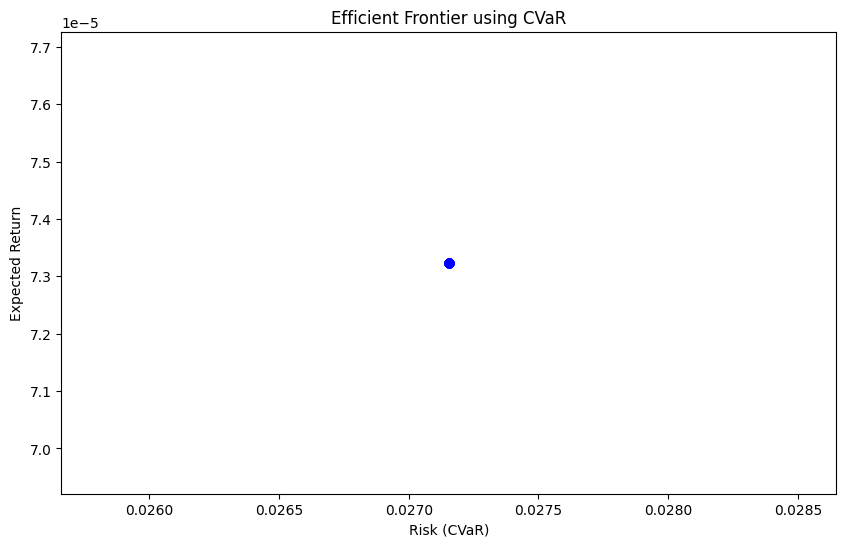

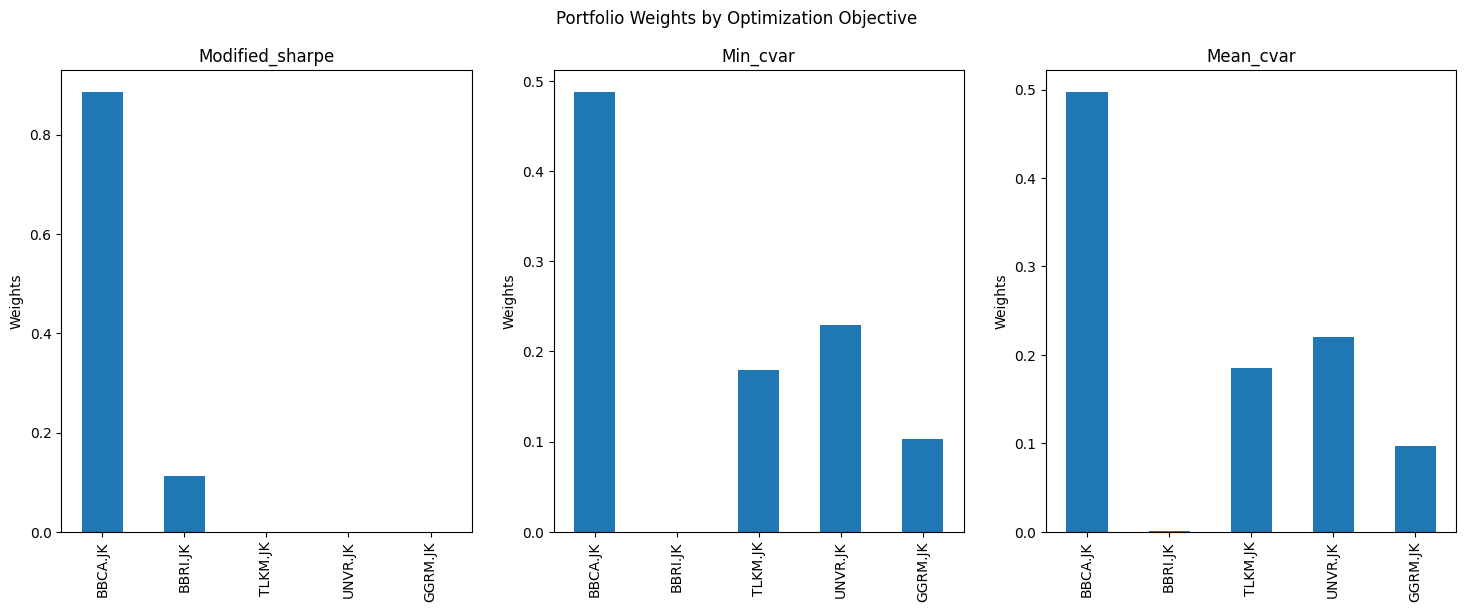


Individual Stock Metrics:
         Mean Return  Volatility  Sharpe Ratio  Skewness   Kurtosis
BBCA.JK     0.000663    0.015976      0.041472  1.063047  13.646702
BBRI.JK     0.000638    0.021022      0.030348  0.912537   9.248467
TLKM.JK     0.000066    0.018669      0.003509  0.662321   5.040380
GGRM.JK    -0.000733    0.023200     -0.031603  0.311012  13.543184
UNVR.JK    -0.000814    0.021629     -0.037624  1.358964  10.583844

Portfolio Results:

Objective: modified_sharpe
Weights:
BBCA.JK    8.866470e-01
BBRI.JK    1.133530e-01
TLKM.JK    2.741053e-17
UNVR.JK    0.000000e+00
GGRM.JK    6.167370e-17
dtype: float64
Metrics:
{'mean_return': 0.0006597522096938727, 'volatility': 0.015612082227439922, 'historical_var_95': 0.020636270525434465, 'historical_cvar_95': 0.032664962590126516, 'modified_sharpe': 0.020197549832593194, 'skewness': 1.1373930907429382, 'kurtosis': 15.780755711391627}

Objective: min_cvar
Weights:
BBCA.JK    4.880435e-01
BBRI.JK    4.336809e-19
TLKM.JK    1.799500

In [3]:
# Daftar kode saham LQ45 terbaru
# Ada beberapa saham yang dieliminasi karena data harga saham baru muncul setelah range yang ditentukan
# AMMN -> 7/7/2023
# BUKA -> 8/6/2021
# GOTO -> 4/11/2022
# MBMA -> 4/18/2023
# MTEL -> 11/22/2021
# PGEO -> 2/24/2023
lq45_tickers = [
    'ACES.JK', 'ADRO.JK', 'AKRA.JK', 'AMRT.JK', 'ANTM.JK',
    'ARTO.JK', 'ASII.JK', 'BBCA.JK', 'BBNI.JK', 'BBRI.JK',
    'BMRI.JK', 'BRIS.JK', 'BRPT.JK', 'CPIN.JK', 'ESSA.JK',
    'EXCL.JK', 'GGRM.JK', 'HRUM.JK', 'ICBP.JK', 'INCO.JK',
    'INDF.JK', 'INKP.JK', 'INTP.JK', 'ISAT.JK', 'ITMG.JK',
    'KLBF.JK', 'MAPI.JK', 'MDKA.JK', 'MEDC.JK', 'BBTN.JK',
    'PGAS.JK', 'PTBA.JK', 'SIDO.JK', 'SMGR.JK', 'TLKM.JK',
    'TOWR.JK', 'UNTR.JK', 'UNVR.JK', 'JSMR.JK',
]
tickers = ['BBCA.JK', 'BBRI.JK', 'TLKM.JK', 'UNVR.JK', 'GGRM.JK']

# Periode analisis
start_date = '2019-09-01'
end_date = '2024-09-01'

results = run_portfolio_analysis(tickers, start_date, end_date)
print("\nIndividual Stock Metrics:")
print(results['stock_metrics'])

print("\nPortfolio Results:")
for objective, data in results['portfolio_results'].items():
    print(f"\nObjective: {objective}")
    print("Weights:")
    print(data['weights'])
    print("Metrics:")
    print(data['metrics'])

print("\nEfficient Frontier Data:")
print(results['frontier_data'])

print("\nBenchmark Performance:")
print(results['benchmark_performance'])

print("\nMonte Carlo Simulation Results (sample):")
print(results['monte_carlo_results'].head())

### Result

Mengunduh data...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********


Berhasil mengunduh data untuk 39 saham

Metrik Individual Saham:
         Mean Return  Volatility  Sharpe Ratio  Skewness   Kurtosis
ARTO.JK     0.004112    0.053714      0.076550  1.729835   8.385520
ADRO.JK     0.001806    0.028252      0.063922  0.371249   3.627930
ITMG.JK     0.001632    0.026530      0.061519  0.846646   4.003567
BRIS.JK     0.002297    0.038930      0.059002  2.540446  13.262119
HRUM.JK     0.001852    0.032575      0.056841  1.279024   5.795596
AMRT.JK     0.001334    0.025041      0.053269  1.263521   6.072998
ISAT.JK     0.001618    0.032503      0.049781  1.659316   8.652612
ESSA.JK     0.001927    0.041364      0.046580  1.613142   7.780513
BMRI.JK     0.000983    0.021386      0.045987  0.193904   5.834546
PTBA.JK     0.001127    0.026310      0.042841  0.880907  10.241339
BBCA.JK     0.000663    0.015976      0.041472  1.063047  13.646702
AKRA.JK     0.001031    0.026319      0.039180  0.761477   3.838968
UNTR.JK     0.000921    0.024674      0.037309  0.

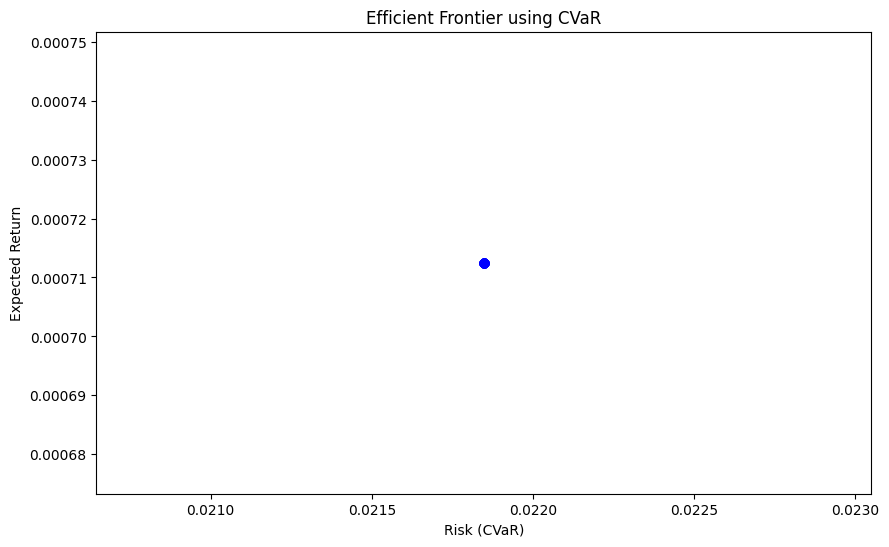

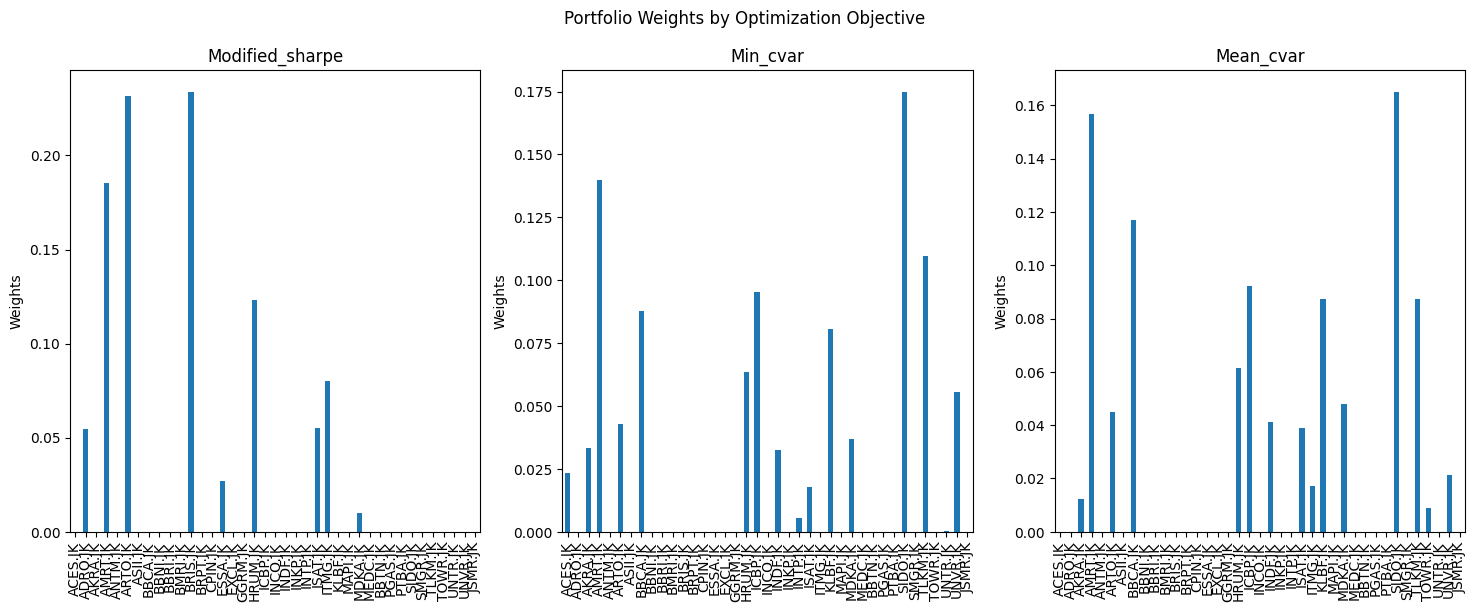


Individual Stock Metrics:
         Mean Return  Volatility  Sharpe Ratio  Skewness   Kurtosis
ARTO.JK     0.004112    0.053714      0.076550  1.729835   8.385520
ADRO.JK     0.001806    0.028252      0.063922  0.371249   3.627930
ITMG.JK     0.001632    0.026530      0.061519  0.846646   4.003567
BRIS.JK     0.002297    0.038930      0.059002  2.540446  13.262119
HRUM.JK     0.001852    0.032575      0.056841  1.279024   5.795596
AMRT.JK     0.001334    0.025041      0.053269  1.263521   6.072998
ISAT.JK     0.001618    0.032503      0.049781  1.659316   8.652612
ESSA.JK     0.001927    0.041364      0.046580  1.613142   7.780513
BMRI.JK     0.000983    0.021386      0.045987  0.193904   5.834546
PTBA.JK     0.001127    0.026310      0.042841  0.880907  10.241339
BBCA.JK     0.000663    0.015976      0.041472  1.063047  13.646702
AKRA.JK     0.001031    0.026319      0.039180  0.761477   3.838968
UNTR.JK     0.000921    0.024674      0.037309  0.983697   6.315244
MEDC.JK     0.001298 

In [4]:
# Daftar kode saham LQ45 terbaru
# Ada beberapa saham yang dieliminasi karena data harga saham baru muncul setelah range yang ditentukan
# AMMN -> 7/7/2023
# BUKA -> 8/6/2021
# GOTO -> 4/11/2022
# MBMA -> 4/18/2023
# MTEL -> 11/22/2021
# PGEO -> 2/24/2023
lq45_tickers = [
    'ACES.JK', 'ADRO.JK', 'AKRA.JK', 'AMRT.JK', 'ANTM.JK',
    'ARTO.JK', 'ASII.JK', 'BBCA.JK', 'BBNI.JK', 'BBRI.JK',
    'BMRI.JK', 'BRIS.JK', 'BRPT.JK', 'CPIN.JK', 'ESSA.JK',
    'EXCL.JK', 'GGRM.JK', 'HRUM.JK', 'ICBP.JK', 'INCO.JK',
    'INDF.JK', 'INKP.JK', 'INTP.JK', 'ISAT.JK', 'ITMG.JK',
    'KLBF.JK', 'MAPI.JK', 'MDKA.JK', 'MEDC.JK', 'BBTN.JK',
    'PGAS.JK', 'PTBA.JK', 'SIDO.JK', 'SMGR.JK', 'TLKM.JK',
    'TOWR.JK', 'UNTR.JK', 'UNVR.JK', 'JSMR.JK',
]
tickers = ['BBCA.JK', 'BBRI.JK', 'TLKM.JK', 'UNVR.JK', 'GGRM.JK']

# Periode analisis
start_date = '2019-09-01'
end_date = '2024-09-01'

results = run_portfolio_analysis(lq45_tickers, start_date, end_date)
print("\nIndividual Stock Metrics:")
print(results['stock_metrics'])

print("\nPortfolio Results:")
for objective, data in results['portfolio_results'].items():
    print(f"\nObjective: {objective}")
    print("Weights:")
    print(data['weights'])
    print("Metrics:")
    print(data['metrics'])

print("\nEfficient Frontier Data:")
print(results['frontier_data'])

print("\nBenchmark Performance:")
print(results['benchmark_performance'])

print("\nMonte Carlo Simulation Results (sample):")
print(results['monte_carlo_results'].head())

### etc

In [ ]:
# --- 5. Visualisasi Efficient Frontier dengan Benchmark ---
def plot_efficient_frontier(monte_carlo_results, benchmark_performance):
    plt.figure(figsize=(12, 8))
    
    # Plot portofolio untuk setiap objektif
    for objective, results in monte_carlo_results.items():
        means = [res['mean_return'] for res in results]
        volatilities = [res['volatility'] for res in results]
        plt.scatter(volatilities, means, label=objective, alpha=0.6)
    
    # Plot benchmark
    plt.scatter(benchmark_performance["Volatility"], benchmark_performance["Mean Return"], color='red', marker='*', s=100, label="Benchmark")

    # Pengaturan dan label plot
    plt.xlabel("Volatility (Risk)")
    plt.ylabel("Mean Return")
    plt.title("Efficient Frontier with Benchmark Comparison")
    plt.legend()
    plt.grid()
    plt.show()
    
# Menampilkan Efficient Frontier
plot_efficient_frontier(results['monte_carlo_results'], results['benchmark_performance'])

In [ ]:
# --- 6. Membandingkan Kinerja Portofolio Optimal dengan Benchmark ---
def compare_portfolio_with_benchmark(portfolio_metrics, benchmark_metrics):
    print("Portfolio Metrics:")
    for key, value in portfolio_metrics.items():
        print(f"{key}: {value}")
    print("\nBenchmark Metrics:")
    for key, value in benchmark_metrics.items():
        print(f"{key}: {value}")
    
    comparison = {
        "Mean Return Diff": portfolio_metrics['mean_return'] - benchmark_metrics['Mean Return'],
        "Volatility Diff": portfolio_metrics['volatility'] - benchmark_metrics['Volatility'],
        "Sharpe Ratio Diff": portfolio_metrics['modified_sharpe'] - benchmark_metrics['Sharpe Ratio']
    }
    print("\nComparison with Benchmark:")
    for key, value in comparison.items():
        print(f"{key}: {value}")
        
# compare_portfolio_with_benchmark(optimal_portfolio_metrics, benchmark_performance)

In [10]:
import pandas as pd
import numpy as np

# Set display options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# If that still doesn't work, you can print each row's weights separately:
print("\nWeights for each portfolio:")
for index, row in results['frontier_data'].iterrows():
    print(f"\nPortfolio {index} weights:")
    weights = np.array(row['weights'])  # Convert to numpy array if not already
    print(np.array2string(weights, precision=10, suppress_small=True, separator=', '))

# Alternative approach using a loop with full precision:
print("\nOr formatted as a list:")
for index, row in results['frontier_data'].iterrows():
    print(f"\nPortfolio {index}:")
    weights = row['weights']
    print([f"{w:.10f}" for w in weights])


Weights for each portfolio:

Portfolio 0 weights:
[0.0235383678, 0.          , 0.0333445628, 0.1397242216, 0.          ,
 0.0428790354, 0.          , 0.0878097031, 0.          , 0.          ,
 0.          , 0.          , 0.          , 0.          , 0.          ,
 0.          , 0.          , 0.0636447675, 0.0954545905, 0.          ,
 0.0325841637, 0.          , 0.0056203734, 0.0177970447, 0.          ,
 0.0805036851, 0.          , 0.0367797721, 0.          , 0.          ,
 0.          , 0.          , 0.1749106092, 0.          , 0.1095785806,
 0.          , 0.000137283 , 0.0556932396, 0.          ]

Portfolio 1 weights:
[0.0235383678, 0.          , 0.0333445628, 0.1397242216, 0.          ,
 0.0428790354, 0.          , 0.0878097031, 0.          , 0.          ,
 0.          , 0.          , 0.          , 0.          , 0.          ,
 0.          , 0.          , 0.0636447675, 0.0954545905, 0.          ,
 0.0325841637, 0.          , 0.0056203734, 0.0177970447, 0.          ,
 0.0805036851, 0. 

In [12]:
print("\nMonte Carlo Simulation Results (sample):")
print(results['monte_carlo_results'])


Monte Carlo Simulation Results (sample):
                                                                                                                                                                                                                                                                  modified_sharpe   
0         {'mean_return': 0.0023815997440519254, 'volatility': 0.01764363123901954, 'historical_var_95': 0.02385965929473082, 'historical_cvar_95': 0.035652347733731445, 'modified_sharpe': 0.06680064274697521, 'skewness': 0.2618711671134157, 'kurtosis': 2.1280149470811462}  \
1         {'mean_return': 0.002365109248314078, 'volatility': 0.018737088385454893, 'historical_var_95': 0.026510423069254135, 'historical_cvar_95': 0.03471434699516393, 'modified_sharpe': 0.06813059881678207, 'skewness': 0.7095546175299849, 'kurtosis': 2.8622028570998372}   
2          {'mean_return': 0.0024942727014916704, 'volatility': 0.018862580803877486, 'historical_var_95': 0.025717870621751324

# Draft 4

In [25]:
class RobustPortfolioOptimizer:
    def __init__(self, returns_data):
        """
        Initialize the optimizer with historical returns data
        
        Parameters:
        returns_data (pd.DataFrame): Historical returns data
        """
        self.returns = returns_data
        self.n_assets = returns_data.shape[1]
        
    def calculate_historical_var(self, weights, confidence_level=0.95):
        """
        Calculate Historical VaR
        """
        portfolio_returns = self.returns @ weights
        return -np.percentile(portfolio_returns, (1 - confidence_level) * 100)
    
    def calculate_historical_cvar(self, weights, confidence_level=0.95):
        """
        Calculate Historical CVaR
        """
        portfolio_returns = self.returns @ weights
        var = -np.percentile(portfolio_returns, (1 - confidence_level) * 100)
        return -np.mean(portfolio_returns[portfolio_returns <= -var])
    
    def calculate_modified_sharpe(self, weights):
        """
        Calculate Modified Sharpe Ratio using CVaR instead of standard deviation
        """
        portfolio_returns = self.returns @ weights
        mean_return = np.mean(portfolio_returns)
        cvar = self.calculate_historical_cvar(weights)
        return mean_return / cvar if cvar != 0 else -np.inf
    
    def optimize_portfolio(self, objective='modified_sharpe', constraints=None, bounds=None, additional_constraints=None):
        """
        Optimize portfolio based on selected objective
        
        Parameters:
        objective (str): 'modified_sharpe', 'min_cvar', or 'mean_cvar'
        constraints (dict): Additional constraints for optimization
        """
        initial_weights = np.array([1/self.n_assets] * self.n_assets)
        
        if bounds is None:
            bounds = [(0, 1) for _ in range(self.n_assets)]
        
        # Basic constraints
        constraints_list = [
            {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}  # weights sum to 1
        ]
        
        if constraints:
            # Add user-defined constraints
            if 'min_weight' in constraints:
                constraints_list.append(
                    {'type': 'ineq', 'fun': lambda x: x - constraints['min_weight']}
                )
            if 'max_weight' in constraints:
                constraints_list.append(
                    {'type': 'ineq', 'fun': lambda x: constraints['max_weight'] - x}
                )
                
        if additional_constraints:
            constraints_list.extend(additional_constraints)
        
        if objective == 'modified_sharpe':
            objective_function = lambda x: -self.calculate_modified_sharpe(x)
        elif objective == 'min_cvar':
            objective_function = lambda x: self.calculate_historical_cvar(x)
        elif objective == 'mean_cvar':
            def objective_function(x):
                returns = np.mean(self.returns @ x)
                cvar = self.calculate_historical_cvar(x)
                return -(returns - 0.5 * cvar)  # Parameter 0.5 can be adjusted
                
        result = minimize(objective_function,
                         initial_weights,
                         method='SLSQP',
                         bounds=bounds,
                         constraints=constraints_list)
        
        # Check if optimization was successful
        if not result.success:
            print("Optimization failed:", result.message)
        
         # Calculate risk (CVaR) for the optimized weights
        optimized_weights = result.x
        optimized_risk = self.calculate_historical_cvar(optimized_weights)
        print(f"Optimized Weights: {optimized_weights}, Optimized Risk: {optimized_risk}")
        
        return result.x
    
    def calculate_portfolio_metrics(self, weights):
        """
        Calculate comprehensive portfolio metrics
        """
        portfolio_returns = self.returns @ weights
        metrics = {
            'mean_return': np.mean(portfolio_returns),
            'volatility': np.std(portfolio_returns),
            'historical_var_95': self.calculate_historical_var(weights),
            'historical_cvar_95': self.calculate_historical_cvar(weights),
            'modified_sharpe': self.calculate_modified_sharpe(weights),
            'skewness': stats.skew(portfolio_returns),
            'kurtosis': stats.kurtosis(portfolio_returns)
        }
        return metrics

In [28]:
import numpy as np
import pandas as pd
import yfinance as yf
from scipy import stats
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

class PortfolioAnalyzer:
    def __init__(self, start_date, end_date):
        self.start_date = start_date
        self.end_date = end_date
        
    def get_data(self, tickers):
        data = pd.DataFrame()
        valid_tickers = []
        
        print("Mengunduh data...")
        for ticker in tickers:
            try:
                stock = yf.download(ticker, start=self.start_date, end=self.end_date)
                if not stock.empty and len(stock) > 0:
                    returns = stock['Adj Close'].pct_change()
                    if len(returns.dropna()) > 0:
                        data[ticker] = returns
                        valid_tickers.append(ticker)
            except Exception as e:
                print(f"Error mengunduh {ticker}: {e}")
                
        data = data.dropna()
        return data, valid_tickers
    
    def analyze_individual_stocks(self, returns_data):
        metrics = pd.DataFrame()
        
        for col in returns_data.columns:
            returns = returns_data[col]
            metrics.loc[col, 'Mean Return'] = returns.mean()
            metrics.loc[col, 'Volatility'] = returns.std()
            metrics.loc[col, 'Sharpe Ratio'] = returns.mean() / returns.std()
            metrics.loc[col, 'Skewness'] = stats.skew(returns)
            metrics.loc[col, 'Kurtosis'] = stats.kurtosis(returns)
            
        return metrics.sort_values('Sharpe Ratio', ascending=False)
    
    def optimize_portfolio(self, returns_data, n_portfolios=1000):
        optimizer = RobustPortfolioOptimizer(returns_data)
        
        results = {
            'modified_sharpe': optimizer.optimize_portfolio(objective='modified_sharpe'),
            'min_cvar': optimizer.optimize_portfolio(objective='min_cvar'),
            'mean_cvar': optimizer.optimize_portfolio(objective='mean_cvar')
        }
        
        portfolio_metrics = {}
        for objective, weights in results.items():
            metrics = optimizer.calculate_portfolio_metrics(weights)
            portfolio_metrics[objective] = {
                'weights': pd.Series(weights, index=returns_data.columns),
                'metrics': metrics
            }
            
        return portfolio_metrics
    
    def generate_efficient_frontier(self, returns_data, n_points=100):
        optimizer = RobustPortfolioOptimizer(returns_data)
        frontier_points = []
        
        min_risk_weights = optimizer.optimize_portfolio(objective='min_cvar')
        max_return_weights = optimizer.optimize_portfolio(objective='modified_sharpe')
        
        min_return = optimizer.calculate_portfolio_metrics(min_risk_weights)['mean_return']
        max_return = optimizer.calculate_portfolio_metrics(max_return_weights)['mean_return']
        print("Min Return:", min_return)
        print("Max Return:", max_return)

        target_returns = np.linspace(min_return, max_return)
        
        for target in target_returns:
            # constraints = [
            #     {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
            #     {'type': 'in    eq', 'fun': lambda x: np.mean(returns_data @ x) - target}
            # ]
            target_return_constraint = [
                {'type': 'eq', 'fun': lambda x: np.mean(returns_data @ x) - target}
            ]
            
            bounds = [(0, 1) for _ in range(returns_data.shape[1])]
            
            weights = optimizer.optimize_portfolio(
                objective='min_cvar', 
                bounds=bounds, 
                additional_constraints=target_return_constraint)
            
            metrics = optimizer.calculate_portfolio_metrics(weights)
            # print(f"Target Return: {target}, Optimized Weights: {weights}")

            frontier_points.append({
                'return': metrics['mean_return'],
                'risk': metrics['historical_cvar_95'],
                'weights': weights
            })
            
        print("Total Points on Frontier:", len(frontier_points))
            
        return pd.DataFrame(frontier_points)
    
    def calculate_benchmark_performance(self, returns_data):
        equal_weights = np.ones(len(returns_data.columns)) / len(returns_data.columns)
        mean_return = np.dot(returns_data.mean(), equal_weights)
        portfolio_std = np.sqrt(np.dot(equal_weights.T, np.dot(returns_data.cov(), equal_weights)))
        sharpe_ratio = mean_return / portfolio_std
        
        return {
            'Mean Return': mean_return,
            'Volatility': portfolio_std,
            'Sharpe Ratio': sharpe_ratio
        }
    
    def monte_carlo_simulation(self, returns_data, n_simulations=1000):
        simulation_results = []
        
        for _ in range(n_simulations):
            simulated_returns = returns_data.sample(frac=1, replace=True)
            optimal_portfolio = self.optimize_portfolio(simulated_returns)
            simulation_results.append({
                'modified_sharpe': optimal_portfolio['modified_sharpe']['metrics'],
                'min_cvar': optimal_portfolio['min_cvar']['metrics'],
                'mean_cvar': optimal_portfolio['mean_cvar']['metrics']
            })
        
        return pd.DataFrame(simulation_results)
    
    def plot_portfolio_weights(self, portfolio_results):
        fig, ax = plt.subplots(1, 3, figsize=(18, 6))
        for idx, (objective, data) in enumerate(portfolio_results.items()):
            data['weights'].plot(kind='bar', ax=ax[idx], title=objective.capitalize())
            ax[idx].set_ylabel("Weights")
        
        plt.suptitle("Portfolio Weights by Optimization Objective")
        plt.show()
    
    def plot_efficient_frontier(self, frontier_data):
        plt.figure(figsize=(10, 6))
        plt.scatter(frontier_data['risk'], frontier_data['return'], c='b', marker='o')
        plt.xlabel('Risk (CVaR)')
        plt.ylabel('Expected Return')
        plt.title('Efficient Frontier using CVaR')
        return plt

def run_portfolio_analysis(tickers, start_date, end_date):
    analyzer = PortfolioAnalyzer(start_date, end_date)
    
    returns_data, valid_tickers = analyzer.get_data(tickers)
    print(f"\nBerhasil mengunduh data untuk {len(valid_tickers)} saham")
    
    stock_metrics = analyzer.analyze_individual_stocks(returns_data)
    print("\nMetrik Individual Saham:")
    print(stock_metrics)
    
    portfolio_results = analyzer.optimize_portfolio(returns_data)
    frontier_data = analyzer.generate_efficient_frontier(returns_data)
    print(frontier_data[['risk', 'return']])
    
    benchmark_performance = analyzer.calculate_benchmark_performance(returns_data)
    print("\nBenchmark Performance:")
    print(benchmark_performance)
    
    # monte_carlo_results = analyzer.monte_carlo_simulation(returns_data)
    # print("\nMonte Carlo Simulation Results (sample):")
    # print(monte_carlo_results.head())
    
    plt = analyzer.plot_efficient_frontier(frontier_data)
    analyzer.plot_portfolio_weights(portfolio_results)
    
    return {
        'returns_data': returns_data,
        'stock_metrics': stock_metrics,
        'portfolio_results': portfolio_results,
        'frontier_data': frontier_data,
        'benchmark_performance': benchmark_performance,
        # 'monte_carlo_results': monte_carlo_results,
        'plot': plt
    }


Mengunduh data...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********


Berhasil mengunduh data untuk 39 saham

Metrik Individual Saham:
         Mean Return  Volatility  Sharpe Ratio  Skewness   Kurtosis
ARTO.JK     0.004112    0.053714      0.076550  1.729835   8.385520
ADRO.JK     0.001806    0.028252      0.063922  0.371250   3.627934
ITMG.JK     0.001632    0.026530      0.061519  0.846645   4.003563
BRIS.JK     0.002297    0.038930      0.059002  2.540447  13.262125
ISAT.JK     0.002156    0.036622      0.058858  4.352178  54.452120
HRUM.JK     0.001852    0.032575      0.056841  1.279024   5.795596
AMRT.JK     0.001334    0.025041      0.053269  1.263519   6.072993
ESSA.JK     0.001927    0.041364      0.046580  1.613142   7.780516
BMRI.JK     0.000983    0.021386      0.045987  0.193904   5.834546
PTBA.JK     0.001127    0.026310      0.042841  0.880907  10.241344
BBCA.JK     0.000663    0.015976      0.041472  1.063045  13.646666
AKRA.JK     0.001031    0.026319      0.039180  0.761476   3.838962
UNTR.JK     0.000921    0.024674      0.037309  0.

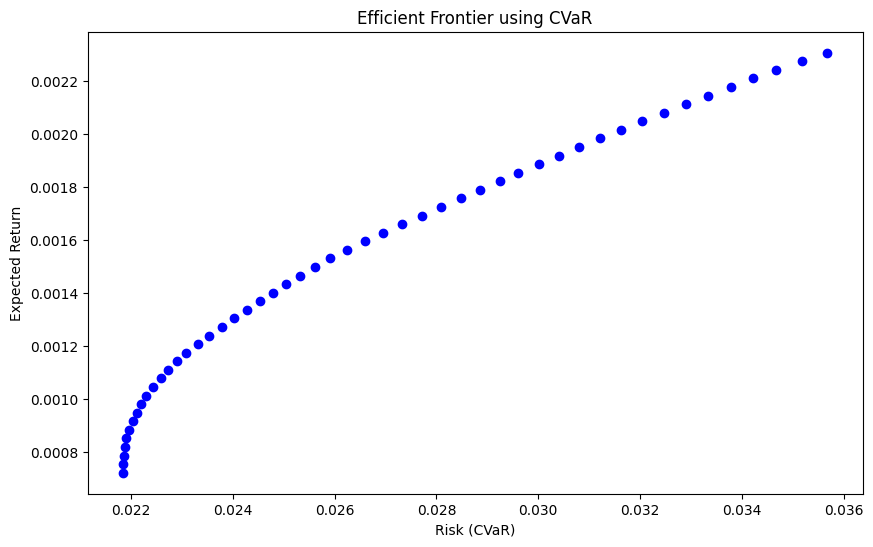

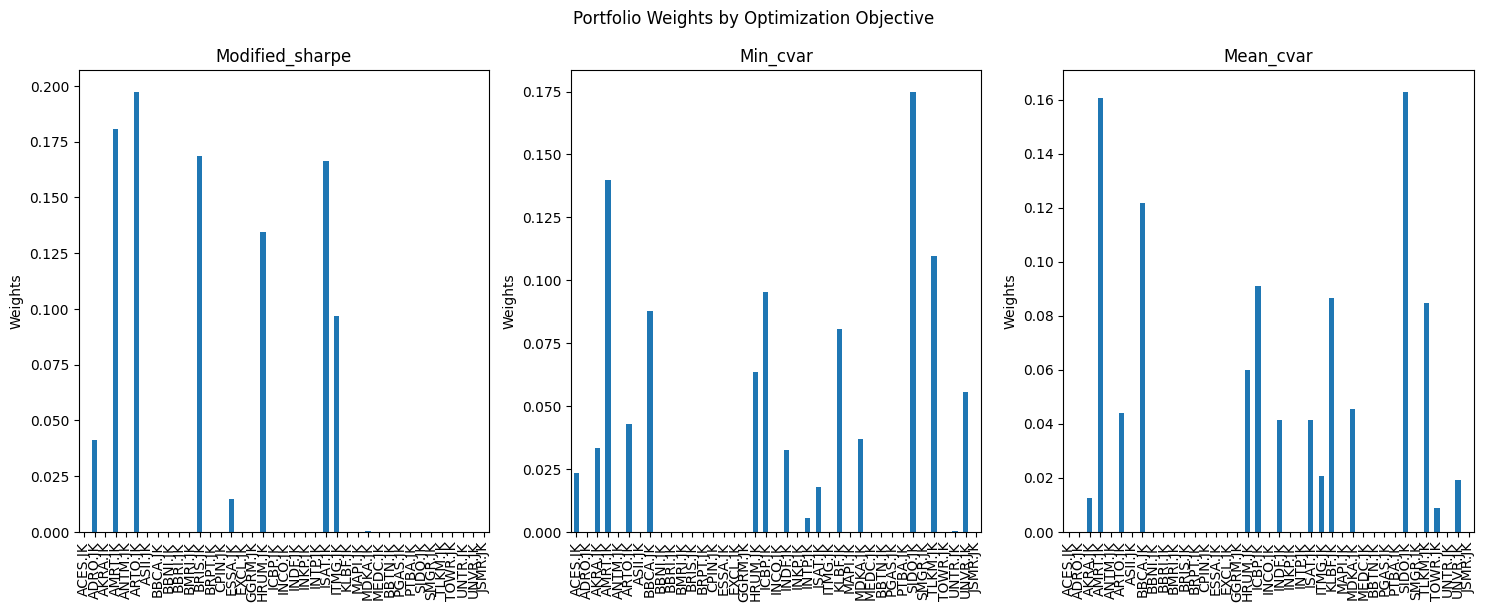


Individual Stock Metrics:
         Mean Return  Volatility  Sharpe Ratio  Skewness   Kurtosis
ARTO.JK     0.004112    0.053714      0.076550  1.729835   8.385520
ADRO.JK     0.001806    0.028252      0.063922  0.371250   3.627934
ITMG.JK     0.001632    0.026530      0.061519  0.846645   4.003563
BRIS.JK     0.002297    0.038930      0.059002  2.540447  13.262125
ISAT.JK     0.002156    0.036622      0.058858  4.352178  54.452120
HRUM.JK     0.001852    0.032575      0.056841  1.279024   5.795596
AMRT.JK     0.001334    0.025041      0.053269  1.263519   6.072993
ESSA.JK     0.001927    0.041364      0.046580  1.613142   7.780516
BMRI.JK     0.000983    0.021386      0.045987  0.193904   5.834546
PTBA.JK     0.001127    0.026310      0.042841  0.880907  10.241344
BBCA.JK     0.000663    0.015976      0.041472  1.063045  13.646666
AKRA.JK     0.001031    0.026319      0.039180  0.761476   3.838962
UNTR.JK     0.000921    0.024674      0.037309  0.983696   6.315238
MEDC.JK     0.001298 

In [30]:
# Daftar kode saham LQ45 terbaru
# Ada beberapa saham yang dieliminasi karena data harga saham baru muncul setelah range yang ditentukan
# AMMN -> 7/7/2023
# BUKA -> 8/6/2021
# GOTO -> 4/11/2022
# MBMA -> 4/18/2023
# MTEL -> 11/22/2021
# PGEO -> 2/24/2023
lq45_tickers = [
    'ACES.JK', 'ADRO.JK', 'AKRA.JK', 'AMRT.JK', 'ANTM.JK',
    'ARTO.JK', 'ASII.JK', 'BBCA.JK', 'BBNI.JK', 'BBRI.JK',
    'BMRI.JK', 'BRIS.JK', 'BRPT.JK', 'CPIN.JK', 'ESSA.JK',
    'EXCL.JK', 'GGRM.JK', 'HRUM.JK', 'ICBP.JK', 'INCO.JK',
    'INDF.JK', 'INKP.JK', 'INTP.JK', 'ISAT.JK', 'ITMG.JK',
    'KLBF.JK', 'MAPI.JK', 'MDKA.JK', 'MEDC.JK', 'BBTN.JK',
    'PGAS.JK', 'PTBA.JK', 'SIDO.JK', 'SMGR.JK', 'TLKM.JK',
    'TOWR.JK', 'UNTR.JK', 'UNVR.JK', 'JSMR.JK',
]
tickers = ['BBCA.JK', 'BBRI.JK', 'TLKM.JK', 'UNVR.JK', 'GGRM.JK']

# Periode analisis
start_date = '2019-09-01'
end_date = '2024-09-01'

results = run_portfolio_analysis(lq45_tickers, start_date, end_date)
print("\nIndividual Stock Metrics:")
print(results['stock_metrics'])

print("\nPortfolio Results:")
for objective, data in results['portfolio_results'].items():
    print(f"\nObjective: {objective}")
    print("Weights:")
    print(data['weights'])
    print("Metrics:")
    print(data['metrics'])

print("\nEfficient Frontier Data:")
print(results['frontier_data'])

print("\nBenchmark Performance:")
print(results['benchmark_performance'])

# print("\nMonte Carlo Simulation Results (sample):")
# print(results['monte_carlo_results'].head())

# Draft 5

In [5]:
class RobustPortfolioOptimizer:
    def __init__(self, returns_data):
        """
        Initialize the optimizer with historical returns data
        
        Parameters:
        returns_data (pd.DataFrame): Historical returns data
        """
        self.returns = returns_data
        self.n_assets = returns_data.shape[1]
        
    def calculate_historical_var(self, weights, confidence_level=0.95):
        """
        Calculate Historical VaR
        """
        portfolio_returns = self.returns @ weights
        return -np.percentile(portfolio_returns, (1 - confidence_level) * 100)
    
    def calculate_historical_cvar(self, weights, confidence_level=0.95):
        """
        Calculate Historical CVaR
        """
        portfolio_returns = self.returns @ weights
        var = -np.percentile(portfolio_returns, (1 - confidence_level) * 100)
        return -np.mean(portfolio_returns[portfolio_returns <= -var])
    
    def calculate_modified_sharpe(self, weights):
        """
        Calculate Modified Sharpe Ratio using CVaR instead of standard deviation
        """
        portfolio_returns = self.returns @ weights
        mean_return = np.mean(portfolio_returns)
        cvar = self.calculate_historical_cvar(weights)
        return mean_return / cvar if cvar != 0 else -np.inf
    
    def optimize_portfolio(self, objective='modified_sharpe', constraints=None, bounds=None, additional_constraints=None):
        """
        Optimize portfolio based on selected objective
        
        Parameters:
        objective (str): 'modified_sharpe', 'min_cvar', or 'mean_cvar'
        constraints (dict): Additional constraints for optimization
        """
        initial_weights = np.array([1/self.n_assets] * self.n_assets)
        
        if bounds is None:
            bounds = [(0, 1) for _ in range(self.n_assets)]
        
        # Basic constraints
        constraints_list = [
            {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}  # weights sum to 1
        ]
        
        if constraints:
            # Add user-defined constraints
            if 'min_weight' in constraints:
                constraints_list.append(
                    {'type': 'ineq', 'fun': lambda x: x - constraints['min_weight']}
                )
            if 'max_weight' in constraints:
                constraints_list.append(
                    {'type': 'ineq', 'fun': lambda x: constraints['max_weight'] - x}
                )
                
        if additional_constraints:
            constraints_list.extend(additional_constraints)
        
        if objective == 'modified_sharpe':
            objective_function = lambda x: -self.calculate_modified_sharpe(x)
        elif objective == 'min_cvar':
            objective_function = lambda x: self.calculate_historical_cvar(x)
        elif objective == 'mean_cvar':
            def objective_function(x):
                returns = np.mean(self.returns @ x)
                cvar = self.calculate_historical_cvar(x)
                return -(returns - 0.5 * cvar)  # Parameter 0.5 can be adjusted
                
        result = minimize(objective_function,
                         initial_weights,
                         method='SLSQP',
                         bounds=bounds,
                         constraints=constraints_list)
        
        # Check if optimization was successful
        if not result.success:
            print("Optimization failed:", result.message)
        
         # Calculate risk (CVaR) for the optimized weights
        optimized_weights = result.x
        optimized_risk = self.calculate_historical_cvar(optimized_weights)
        print(f"Optimized Weights: {optimized_weights}, Optimized Risk: {optimized_risk}")
        
        return result.x
    
    def calculate_portfolio_metrics(self, weights):
        """
        Calculate comprehensive portfolio metrics
        """
        portfolio_returns = self.returns @ weights
        metrics = {
            'mean_return': np.mean(portfolio_returns),
            'volatility': np.std(portfolio_returns),
            'historical_var_95': self.calculate_historical_var(weights),
            'historical_cvar_95': self.calculate_historical_cvar(weights),
            'modified_sharpe': self.calculate_modified_sharpe(weights),
            'skewness': stats.skew(portfolio_returns),
            'kurtosis': stats.kurtosis(portfolio_returns)
        }
        return metrics

In [6]:
import numpy as np
import pandas as pd
import yfinance as yf
from scipy import stats
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

class PortfolioAnalyzer:
    def __init__(self, start_date, end_date):
        self.start_date = start_date
        self.end_date = end_date
        
    def get_data(self, tickers):
        data = pd.DataFrame()
        valid_tickers = []
        
        print("Mengunduh data...")
        for ticker in tickers:
            try:
                stock = yf.download(ticker, start=self.start_date, end=self.end_date)
                if not stock.empty and len(stock) > 0:
                    returns = stock['Adj Close'].pct_change()
                    if len(returns.dropna()) > 0:
                        data[ticker] = returns
                        valid_tickers.append(ticker)
            except Exception as e:
                print(f"Error mengunduh {ticker}: {e}")
                
        data = data.dropna()
        return data, valid_tickers
    
    def analyze_individual_stocks(self, returns_data):
        metrics = pd.DataFrame()
        
        for col in returns_data.columns:
            returns = returns_data[col]
            metrics.loc[col, 'Mean Return'] = returns.mean()
            metrics.loc[col, 'Volatility'] = returns.std()
            metrics.loc[col, 'Sharpe Ratio'] = returns.mean() / returns.std()
            metrics.loc[col, 'Skewness'] = stats.skew(returns)
            metrics.loc[col, 'Kurtosis'] = stats.kurtosis(returns)
            
        return metrics.sort_values('Sharpe Ratio', ascending=False)
    
    def optimize_portfolio(self, returns_data, n_portfolios=1000):
        optimizer = RobustPortfolioOptimizer(returns_data)
        
        results = {
            'modified_sharpe': optimizer.optimize_portfolio(objective='modified_sharpe'),
            'min_cvar': optimizer.optimize_portfolio(objective='min_cvar'),
            'mean_cvar': optimizer.optimize_portfolio(objective='mean_cvar')
        }
        
        portfolio_metrics = {}
        for objective, weights in results.items():
            metrics = optimizer.calculate_portfolio_metrics(weights)
            portfolio_metrics[objective] = {
                'weights': pd.Series(weights, index=returns_data.columns),
                'metrics': metrics
            }
            
        return portfolio_metrics
    
    def generate_efficient_frontier(self, returns_data, n_points=100):
        optimizer = RobustPortfolioOptimizer(returns_data)
        frontier_points = []
        
        min_risk_weights = optimizer.optimize_portfolio(objective='min_cvar')
        max_return_weights = optimizer.optimize_portfolio(objective='modified_sharpe')
        
        min_return = optimizer.calculate_portfolio_metrics(min_risk_weights)['mean_return']
        max_return = optimizer.calculate_portfolio_metrics(max_return_weights)['mean_return']
        print("Min Return:", min_return)
        print("Max Return:", max_return)

        target_returns = np.linspace(min_return, max_return)
        
        for target in target_returns:
            # constraints = [
            #     {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
            #     {'type': 'in    eq', 'fun': lambda x: np.mean(returns_data @ x) - target}
            # ]
            target_return_constraint = [
                {'type': 'eq', 'fun': lambda x: np.mean(returns_data @ x) - target}
            ]
            
            bounds = [(0, 1) for _ in range(returns_data.shape[1])]
            
            weights = optimizer.optimize_portfolio(
                objective='min_cvar', 
                bounds=bounds, 
                additional_constraints=target_return_constraint)
            
            metrics = optimizer.calculate_portfolio_metrics(weights)
            # print(f"Target Return: {target}, Optimized Weights: {weights}")

            frontier_points.append({
                'return': metrics['mean_return'],
                'risk': metrics['historical_cvar_95'],
                'weights': weights
            })
            
        print("Total Points on Frontier:", len(frontier_points))
            
        return pd.DataFrame(frontier_points)
    
    def calculate_benchmark_performance(self, returns_data):
        equal_weights = np.ones(len(returns_data.columns)) / len(returns_data.columns)
        mean_return = np.dot(returns_data.mean(), equal_weights)
        portfolio_std = np.sqrt(np.dot(equal_weights.T, np.dot(returns_data.cov(), equal_weights)))
        sharpe_ratio = mean_return / portfolio_std
        
        return {
            'Mean Return': mean_return,
            'Volatility': portfolio_std,
            'Sharpe Ratio': sharpe_ratio
        }
    
    def monte_carlo_simulation(self, returns_data, n_simulations=1000):
        simulation_results = []
        
        for _ in range(n_simulations):
            simulated_returns = returns_data.sample(frac=1, replace=True)
            optimal_portfolio = self.optimize_portfolio(simulated_returns)
            simulation_results.append({
                'modified_sharpe': optimal_portfolio['modified_sharpe']['metrics'],
                'min_cvar': optimal_portfolio['min_cvar']['metrics'],
                'mean_cvar': optimal_portfolio['mean_cvar']['metrics']
            })
        
        return pd.DataFrame(simulation_results)
    
    def plot_portfolio_weights(self, portfolio_results):
        fig, ax = plt.subplots(1, 3, figsize=(18, 6))
        for idx, (objective, data) in enumerate(portfolio_results.items()):
            data['weights'].plot(kind='bar', ax=ax[idx], title=objective.capitalize())
            ax[idx].set_ylabel("Weights")
        
        plt.suptitle("Portfolio Weights by Optimization Objective")
        plt.show()
    
    def plot_efficient_frontier(self, frontier_data):
        plt.figure(figsize=(10, 6))
        plt.scatter(frontier_data['risk'], frontier_data['return'], c='b', marker='o')
        plt.xlabel('Risk (CVaR)')
        plt.ylabel('Expected Return')
        plt.title('Efficient Frontier using CVaR')
        return plt

def run_individual_analysis(tickers, start_date, end_date):
    analyzer = PortfolioAnalyzer(start_date, end_date)
    
    returns_data, valid_tickers = analyzer.get_data(tickers)
    print(f"\nBerhasil mengunduh data untuk {len(valid_tickers)} saham")
    
    stock_metrics = analyzer.analyze_individual_stocks(returns_data)
    print("\nMetrik Individual Saham:")
    print(stock_metrics)
    
    return {
        'returns_data': returns_data,
        'stock_metrics': stock_metrics,
    }

def run_portfolio_analysis(tickers, start_date, end_date):
    analyzer = PortfolioAnalyzer(start_date, end_date)
    
    returns_data, valid_tickers = analyzer.get_data(tickers)
    print(f"\nBerhasil mengunduh data untuk {len(valid_tickers)} saham")
    
    stock_metrics = analyzer.analyze_individual_stocks(returns_data)
    print("\nMetrik Individual Saham:")
    print(stock_metrics)
    
    portfolio_results = analyzer.optimize_portfolio(returns_data)
    frontier_data = analyzer.generate_efficient_frontier(returns_data)
    print(frontier_data[['risk', 'return']])
    
    benchmark_performance = analyzer.calculate_benchmark_performance(returns_data)
    print("\nBenchmark Performance:")
    print(benchmark_performance)
    
    # monte_carlo_results = analyzer.monte_carlo_simulation(returns_data)
    # print("\nMonte Carlo Simulation Results (sample):")
    # print(monte_carlo_results.head())
    
    plt = analyzer.plot_efficient_frontier(frontier_data)
    analyzer.plot_portfolio_weights(portfolio_results)
    
    return {
        'returns_data': returns_data,
        'stock_metrics': stock_metrics,
        'portfolio_results': portfolio_results,
        'frontier_data': frontier_data,
        'benchmark_performance': benchmark_performance,
        # 'monte_carlo_results': monte_carlo_results,
        'plot': plt
    }


In [3]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import yfinance as yf

class LQ45Analyzer:
    def __init__(self, lq45_compositions):
        """
        Inisialisasi analyzer dengan data komposisi LQ45
        
        Parameters:
        - lq45_compositions (list): Daftar komposisi LQ45 dalam periode tertentu
        """
        self.df = pd.DataFrame(lq45_compositions, columns=[
            'period', 'stock_code', 'start_date', 'end_date'
        ])
        
    def get_consistent_stocks(self, min_consistency=0.7):
        """
        Identifikasi saham yang konsisten dalam indeks LQ45
        
        Parameters:
        - min_consistency (float): Persentase minimum keberadaan di indeks
        
        Returns:
        - DataFrame berisi saham-saham yang konsisten
        """
        # Hitung frekuensi keberadaan setiap saham
        stock_frequency = self.df['stock_code'].value_counts()
        total_periods = len(self.df['period'].unique())
        
        # Filter saham berdasarkan konsistensi
        consistent_stocks = stock_frequency[
            stock_frequency / total_periods >= min_consistency
        ]
        
        return self.df[self.df['stock_code'].isin(consistent_stocks.index)]
    
    def generate_stock_timeline(self):
        """
        Buat timeline keberadaan saham di LQ45
        
        Returns:
        - DataFrame berisi timeline saham
        """
        # stock_timeline = self.df.groupby('stock_code').agg({
        #     'start_date': 'min',
        #     'end_date': 'max',
        # }).reset_index()
        
        # return stock_timeline
        unique_stocks = self.df['stock_code'].drop_duplicates().reset_index(drop=True)
        return unique_stocks
    
    # def export_consistent_stocks(self, output_file='./lq45/consistent_lq45_stocks.csv'):
    #     """
    #     Ekspor daftar saham konsisten ke CSV
        
    #     Parameters:
    #     - output_file (str): Nama file output
    #     """
    #     # consistent_stocks = self.get_consistent_stocks()
    #     # consistent_stocks.to_csv(output_file, index=False)
    #     # print(f"Exported {len(consistent_stocks)} consistent stocks to {output_file}")
    #     # Extract unique stock codes
    #     unique_stocks = self.df['stock_code'].drop_duplicates().reset_index(drop=True)
    #     unique_stocks.to_frame(name='stock_code').to_csv(output_file, index=False)
    #     print(f"Exported {len(unique_stocks)} unique stocks to {output_file}")
    def export_consistent_stocks(self, output_file='./lq45/consistent_lq45_stocks.csv', min_consistency=0.7):
        """
        Ekspor daftar saham konsisten dengan pengecekan data Yahoo Finance
        
        Parameters:
        - output_file (str): Nama file output
        - min_consistency (float): Persentase minimum keberadaan di indeks untuk dianggap konsisten
        """
        today = datetime.today().strftime('%Y-%m-%d')
        start_date = '2020-02-03'

        # Calculate consistency for each stock
        stock_frequency = self.df['stock_code'].value_counts()
        total_periods = len(self.df['period'].unique())
        
        # Filter stocks by consistency
        consistent_stocks = stock_frequency[stock_frequency / total_periods >= min_consistency]
        consistent_stock_codes = consistent_stocks.index.tolist()
        
        # Check data availability on Yahoo Finance
        valid_stocks = []
        tickers = []
        for stock in consistent_stock_codes:
            try:
                data = yf.download(stock + '.JK', start=start_date, end=today, progress=False)
                if not data.empty:
                    valid_stocks.append(stock)
                    tickers.append(stock + '.JK')
            except Exception as e:
                print(f"Error fetching data for {stock}: {e}")
        
        # Create DataFrame with valid stocks and consistency
        consistency_df = pd.DataFrame({
            'stock_code': valid_stocks,
            'consistency': [consistent_stocks[stock] / total_periods for stock in valid_stocks],
            'ticker': tickers
        })
        
        # Export to CSV
        consistency_df.to_csv(output_file, index=False)
        print(f"Exported {len(consistency_df)} consistent stocks with valid data to {output_file}")

In [23]:
# Contoh penggunaan
summary_df = pd.read_csv('./lq45/summary.csv')
lq45_compositions = summary_df.to_dict(orient='records')

analyzer = LQ45Analyzer(lq45_compositions)
# consistent_stocks = analyzer.get_consistent_stocks()
analyzer.export_consistent_stocks(output_file="./lq45/consistent_lq45_stocks.csv")

# print("Saham Konsisten:")
# print(consistent_stocks)

# analyzer.export_consistent_stocks()

# # Contoh generate timeline
# stock_timeline = analyzer.generate_stock_timeline()
# print("\nTimeline Saham:")
# print(stock_timeline)

Exported 32 consistent stocks with valid data to ./lq45/consistent_lq45_stocks.csv


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Mengunduh data...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%*******


Berhasil mengunduh data untuk 32 saham

Metrik Individual Saham:
         Mean Return  Volatility  Sharpe Ratio  Skewness   Kurtosis
ADRO.JK     0.001806    0.028252      0.063922  0.371250   3.627939
ITMG.JK     0.001632    0.026530      0.061519  0.846646   4.003569
BMRI.JK     0.000983    0.021386      0.045987  0.193904   5.834537
PTBA.JK     0.001127    0.026310      0.042841  0.880908  10.241344
BBCA.JK     0.000663    0.015976      0.041472  1.063045  13.646684
AKRA.JK     0.001031    0.026319      0.039180  0.761477   3.838966
UNTR.JK     0.000921    0.024674      0.037309  0.983695   6.315232
MEDC.JK     0.001298    0.035320      0.036758  0.765251   3.686769
MDKA.JK     0.001038    0.030823      0.033682  0.939475   4.509056
TBIG.JK     0.000804    0.026177      0.030705  1.360718   9.983655
BBRI.JK     0.000638    0.021022      0.030348  0.912538   9.248480
BBNI.JK     0.000634    0.021758      0.029161  0.366602   5.160575
TOWR.JK     0.000517    0.021440      0.024098  0.

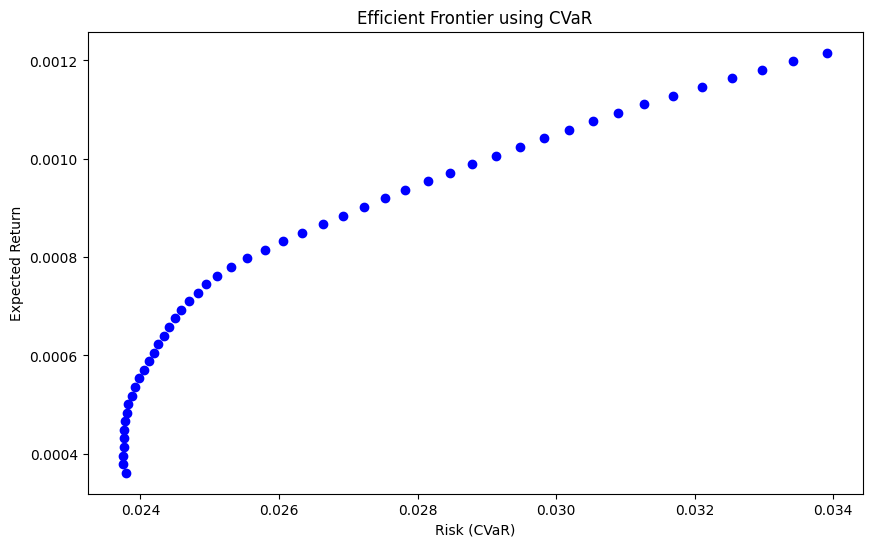

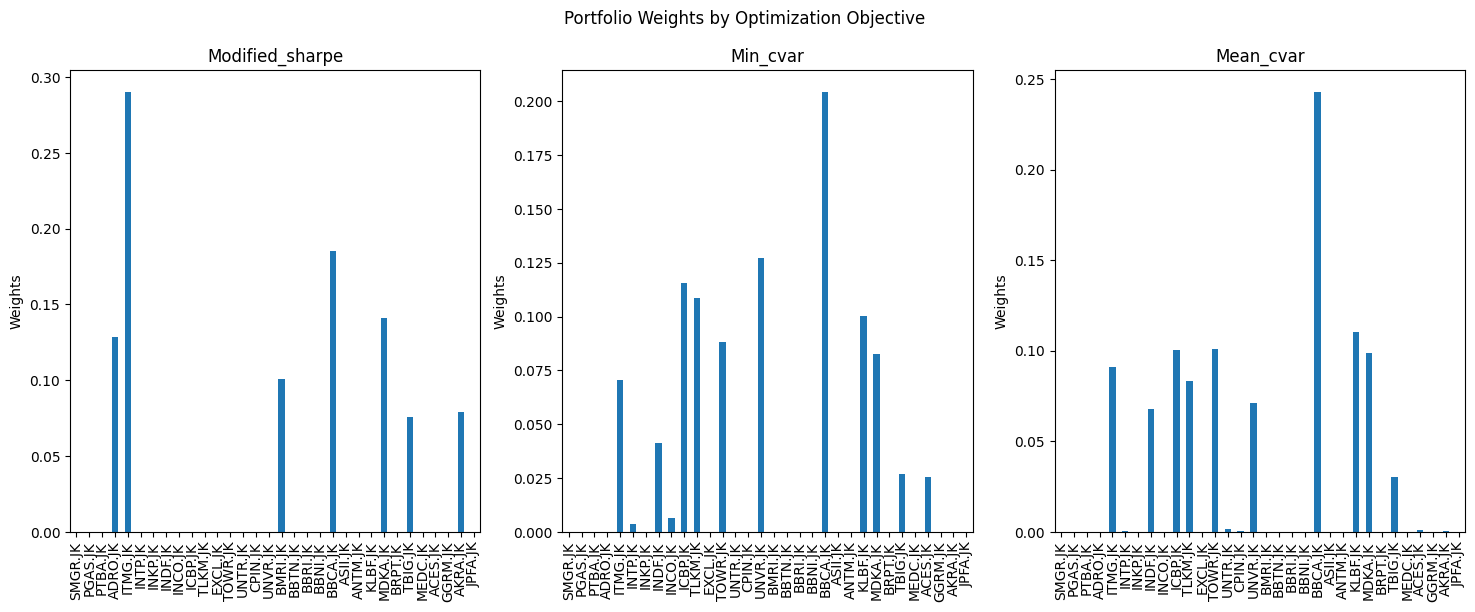


Individual Stock Metrics:
         Mean Return  Volatility  Sharpe Ratio  Skewness   Kurtosis
ADRO.JK     0.001806    0.028252      0.063922  0.371250   3.627939
ITMG.JK     0.001632    0.026530      0.061519  0.846646   4.003569
BMRI.JK     0.000983    0.021386      0.045987  0.193904   5.834537
PTBA.JK     0.001127    0.026310      0.042841  0.880908  10.241344
BBCA.JK     0.000663    0.015976      0.041472  1.063045  13.646684
AKRA.JK     0.001031    0.026319      0.039180  0.761477   3.838966
UNTR.JK     0.000921    0.024674      0.037309  0.983695   6.315232
MEDC.JK     0.001298    0.035320      0.036758  0.765251   3.686769
MDKA.JK     0.001038    0.030823      0.033682  0.939475   4.509056
TBIG.JK     0.000804    0.026177      0.030705  1.360718   9.983655
BBRI.JK     0.000638    0.021022      0.030348  0.912538   9.248480
BBNI.JK     0.000634    0.021758      0.029161  0.366602   5.160575
TOWR.JK     0.000517    0.021440      0.024098  0.847328   7.135177
ANTM.JK     0.000744 

In [7]:
lq45_tickers = pd.read_csv('./lq45/consistent_lq45_stocks.csv')['ticker']

# Periode analisis
start_date = '2019-09-01'
end_date = '2024-09-01'

results = run_portfolio_analysis(lq45_tickers, start_date, end_date)
print("\nIndividual Stock Metrics:")
print(results['stock_metrics'])

print("\nPortfolio Results:")
for objective, data in results['portfolio_results'].items():
    print(f"\nObjective: {objective}")
    print("Weights:")
    print(data['weights'])
    print("Metrics:")
    print(data['metrics'])

In [8]:
results['portfolio_results']

{'modified_sharpe': {'weights': SMGR.JK    1.512457e-17
  PGAS.JK    0.000000e+00
  PTBA.JK    0.000000e+00
  ADRO.JK    1.282408e-01
  ITMG.JK    2.903103e-01
  INTP.JK    4.395787e-17
  INKP.JK    2.823921e-17
  INDF.JK    0.000000e+00
  INCO.JK    0.000000e+00
  ICBP.JK    0.000000e+00
  TLKM.JK    0.000000e+00
  EXCL.JK    0.000000e+00
  TOWR.JK    0.000000e+00
  UNTR.JK    4.819289e-18
  CPIN.JK    0.000000e+00
  UNVR.JK    1.006843e-17
  BMRI.JK    1.005603e-01
  BBTN.JK    0.000000e+00
  BBRI.JK    0.000000e+00
  BBNI.JK    0.000000e+00
  BBCA.JK    1.850054e-01
  ASII.JK    5.716339e-18
  ANTM.JK    9.495020e-18
  KLBF.JK    0.000000e+00
  MDKA.JK    1.412700e-01
  BRPT.JK    0.000000e+00
  TBIG.JK    7.554237e-02
  MEDC.JK    0.000000e+00
  ACES.JK    7.282556e-18
  GGRM.JK    6.746350e-18
  AKRA.JK    7.907080e-02
  JPFA.JK    2.776617e-18
  dtype: float64,
  'metrics': {'mean_return': 0.0012157946493554818,
   'volatility': 0.016030470653884476,
   'historical_var_95': 0.022

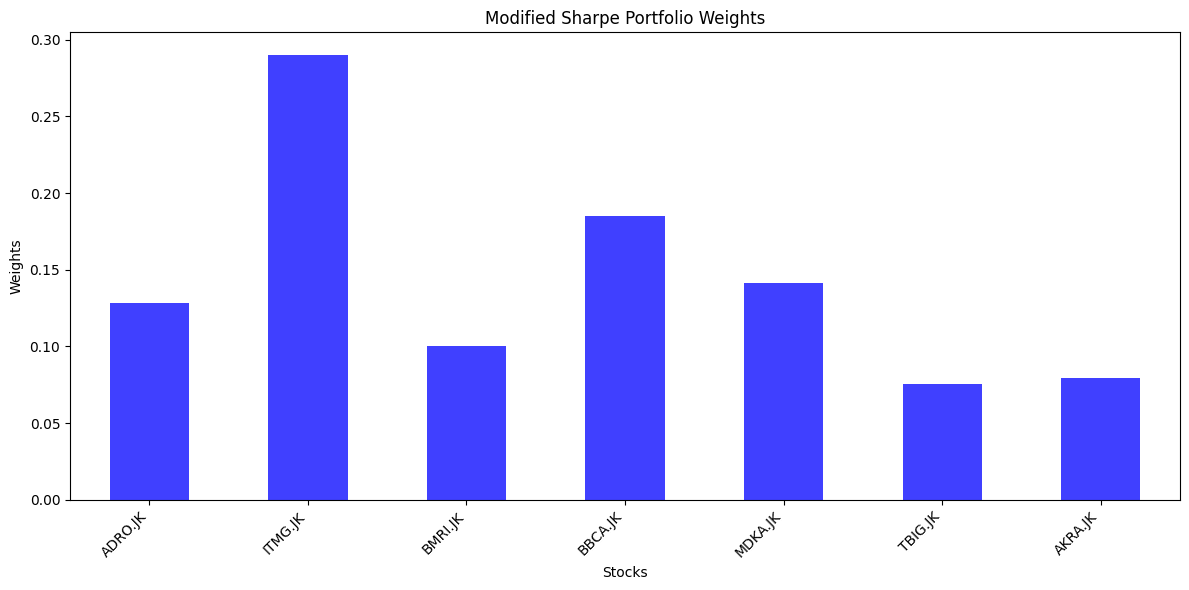

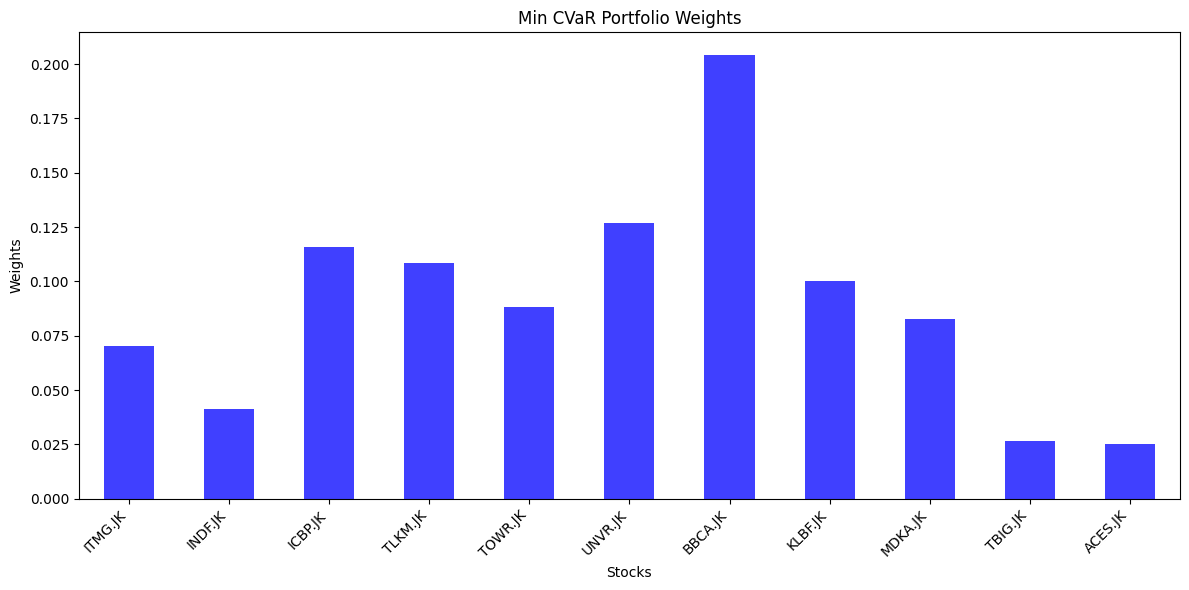

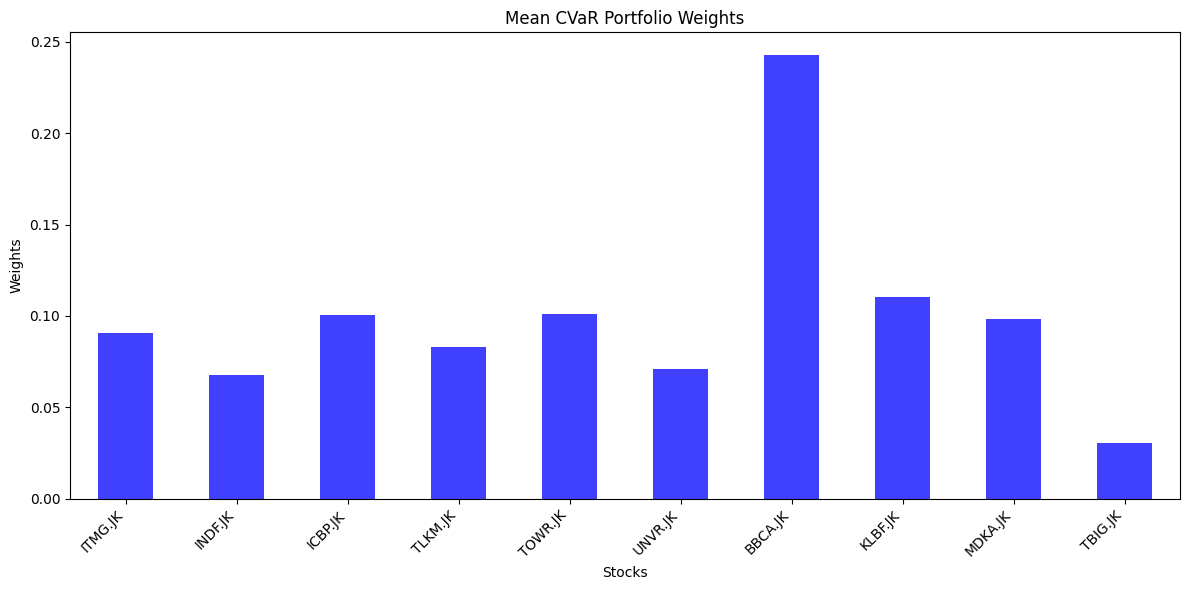

In [ ]:
import matplotlib.pyplot as plt

# Portfolio weights dictionary from your results
port/folios = {
    "Modified Sharpe": results['portfolio_results']['modified_sharpe']['weights'],
    "Min CVaR": results['portfolio_results']['min_cvar']['weights'],
    "Mean CVaR": results['portfolio_results']['mean_cvar']['weights']
}

# Create separate bar plots for each portfolio
for portfolio_name, weights in portfolios.items():
    # Filter weights greater than 0
    positive_weights = weights[weights > 0.01]
    
    plt.figure(figsize=(12, 6))
    positive_weights.plot(kind='bar', color='blue', alpha=0.75)
    plt.title(f"{portfolio_name} Portfolio Weights")
    plt.xlabel("Stocks")
    plt.ylabel("Weights")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


In [18]:
print("\nEfficient Frontier Data:")
print(results['frontier_data'])



Efficient Frontier Data:
      return      risk                                            weights
0   0.000362  0.023795  [5.002832431454663e-20, 0.0, 4.220207934402912...
1   0.000379  0.023744  [0.0, 0.0, 1.496014962486917e-18, 1.0431848006...
2   0.000396  0.023752  [0.0, 1.900206785673121e-18, 2.638713691289442...
3   0.000414  0.023756  [0.0, 0.0, 0.0, 0.0, 0.07580180412431224, 0.00...
4   0.000431  0.023758  [1.882719917135261e-18, 5.8640731969197674e-18...
5   0.000449  0.023768  [1.1167176805547168e-18, 2.773269638016794e-18...
6   0.000466  0.023777  [5.136659233799808e-18, 0.0, 1.007357933205018...
7   0.000484  0.023799  [4.540998434810719e-18, 4.376933335654161e-19,...
8   0.000501  0.023824  [8.843753682772036e-18, 4.125503444434164e-18,...
9   0.000518  0.023873  [2.8140160662199662e-18, 8.922598699428924e-19...
10  0.000536  0.023924  [0.0, 1.0511418981452987e-18, 6.05633926794593...
11  0.000553  0.023984  [1.513814583829529e-20, 2.1873307609231377e-18...
12  0.000571

In [20]:
print("\nEfficient Frontier Data:")
print(results['frontier_data'][['risk', 'return']])


Efficient Frontier Data:
        risk    return
0   0.023795  0.000362
1   0.023744  0.000379
2   0.023752  0.000396
3   0.023756  0.000414
4   0.023758  0.000431
5   0.023768  0.000449
6   0.023777  0.000466
7   0.023799  0.000484
8   0.023824  0.000501
9   0.023873  0.000518
10  0.023924  0.000536
11  0.023984  0.000553
12  0.024055  0.000571
13  0.024117  0.000588
14  0.024198  0.000606
15  0.024257  0.000623
16  0.024338  0.000641
17  0.024405  0.000658
18  0.024499  0.000675
19  0.024583  0.000693
20  0.024698  0.000710
21  0.024824  0.000728
22  0.024946  0.000745
23  0.025100  0.000763
24  0.025305  0.000780
25  0.025542  0.000797
26  0.025802  0.000815
27  0.026060  0.000832
28  0.026334  0.000850
29  0.026630  0.000867
30  0.026928  0.000885
31  0.027231  0.000902
32  0.027531  0.000919
33  0.027825  0.000937
34  0.028146  0.000954
35  0.028475  0.000972
36  0.028788  0.000989
37  0.029126  0.001007
38  0.029478  0.001024
39  0.029825  0.001041
40  0.030181  0.001059
41  0.03

In [28]:
print("\nBenchmark Performance:")
print(results['benchmark_performance'])



Benchmark Performance:
{'Mean Return': 0.00047792752567721135, 'Volatility': 0.01347839721104971, 'Sharpe Ratio': 0.035458780312944194}


In [29]:
print("\nMonte Carlo Simulation Results (sample):")
print(results['monte_carlo_results'].head())



Monte Carlo Simulation Results (sample):
                                     modified_sharpe   
0  {'mean_return': 0.0014503664995318614, 'volati...  \
1  {'mean_return': 0.0019409443087076107, 'volati...   
2  {'mean_return': 0.0010335821884487175, 'volati...   
3  {'mean_return': 0.001481765321263713, 'volatil...   
4  {'mean_return': 0.0023701251791226944, 'volati...   

                                            min_cvar   
0  {'mean_return': 0.0003099972348767486, 'volati...  \
1  {'mean_return': 0.0005764018857974355, 'volati...   
2  {'mean_return': -7.33436548144438e-05, 'volati...   
3  {'mean_return': -0.00014316633691968943, 'vola...   
4  {'mean_return': 0.0009742520809062804, 'volati...   

                                           mean_cvar  
0  {'mean_return': 0.0005652336458157634, 'volati...  
1  {'mean_return': 0.0007483897936134729, 'volati...  
2  {'mean_return': -0.000142248083295173, 'volati...  
3  {'mean_return': -0.00013114816964493882, 'vola...  
4  {'mean

In [36]:
lq45_tickers = pd.read_csv('./lq45/consistent_lq45_stocks.csv')['ticker']

# Periode analisis
start_date = '2019-09-01'
end_date = '2024-09-01'

results = run_individual_analysis(lq45_tickers, start_date, end_date)
print("\nIndividual Stock Metrics:")
print(results['stock_metrics'])

[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Mengunduh data...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%*******


Berhasil mengunduh data untuk 32 saham

Metrik Individual Saham:
         Mean Return  Volatility  Sharpe Ratio  Skewness   Kurtosis
ADRO.JK     0.001806    0.028252      0.063922  0.371252   3.627944
ITMG.JK     0.001632    0.026530      0.061519  0.846647   4.003572
BMRI.JK     0.000983    0.021386      0.045987  0.193904   5.834542
PTBA.JK     0.001127    0.026310      0.042841  0.880908  10.241350
BBCA.JK     0.000663    0.015976      0.041472  1.063041  13.646615
AKRA.JK     0.001031    0.026319      0.039180  0.761478   3.838971
UNTR.JK     0.000921    0.024674      0.037309  0.983696   6.315247
MEDC.JK     0.001298    0.035320      0.036758  0.765251   3.686770
MDKA.JK     0.001038    0.030823      0.033682  0.939475   4.509056
TBIG.JK     0.000804    0.026177      0.030705  1.360718   9.983672
BBRI.JK     0.000638    0.021022      0.030348  0.912536   9.248449
BBNI.JK     0.000634    0.021758      0.029161  0.366601   5.160575
TOWR.JK     0.000517    0.021440      0.024098  0.